In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv("train.csv")
df_test  = pd.read_csv("test.csv")

print(df_train.shape, df_test.shape)
df_train.info()
df_train.describe()
df_train.isna().sum()


(11018, 36) (5000, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11018 entries, 0 to 11017
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10488 non-null  object 
 1   Age                         10488 non-null  float64
 2   AnnualIncome                10488 non-null  float64
 3   CreditScore                 9987 non-null   float64
 4   LoanAmount                  9987 non-null   float64
 5   LoanDuration                10488 non-null  float64
 6   MaritalStatus               10488 non-null  object 
 7   NumberOfDependents          10488 non-null  float64
 8   HomeOwnershipStatus         10488 non-null  object 
 9   MonthlyDebtPayments         9987 non-null   float64
 10  CreditCardUtilizationRate   10488 non-null  float64
 11  NumberOfOpenCreditLines     10488 non-null  float64
 12  NumberOfCreditInquiries     10488 non-null  float64
 13  DebtToIn

ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 530
Experience          

#  Предусловие: Описание признаков (до обработки)

Перед началом предобработки важно понимать, что означает каждый признак в исходном датасете:

| Признак | Описание |
|--------|----------|
| `Age` | Возраст заёмщика |
| `LoanAmount` | Запрашиваемая сумма займа |
| `LoanDuration` | Срок займа в месяцах |
| `MonthlyIncome` | Ежемесячный доход |
| `MonthlyDebtPayments` | Сумма всех ежемесячных выплат по долгам |
| `SavingsAccountBalance` | Баланс сберегательного счёта |
| `CheckingAccountBalance` | Баланс расчетного счёта |
| `TotalAssets` | Суммарная стоимость активов |
| `TotalLiabilities` | Общая сумма долгов |
| `NetWorth` | Чистый капитал (TotalAssets – TotalLiabilities) |
| `DebtToIncomeRatio` | Соотношение долга к доходу |
| `TotalDebtToIncomeRatio` | Расширенное соотношение долгов к доходу |
| `CreditCardUtilizationRate` | Использование кредитного лимита |
| `CreditScore` | Кредитный скоринг (от 300 до 850) |
| `NumberOfDependents` | Количество иждивенцев |
| `NumberOfOpenCreditLines` | Активные кредитные линии |
| `NumberOfCreditInquiries` | Запросы в кредитную историю |
| `BankruptcyHistory` | Были ли банкротства (0/1) |
| `PreviousLoanDefaults` | Были ли дефолты по займам |
| `PaymentHistory` | Качество истории платежей (0–1) |
| `JobTenure` | Стаж на текущем месте работы (в месяцах) |
| `EmploymentStatus` | Статус занятости (работает, безработный, самозанятый и т.д.) |
| `MaritalStatus` | Семейное положение |
| `HomeOwnershipStatus` | Тип жилья: собственное, аренда и т.п. |
| `LoanPurpose` | Цель займа (образование, дом, консолидация долга и т.д.) |
| `EducationLevel` | Уровень образования |
| `ApplicationDate` | Дата подачи заявки |
| `InterestRate` | Назначенная ставка по займу |
| `BaseInterestRate` | Базовая процентная ставка |
| `LoanApproved` | Был ли займ одобрен (0/1) |
| `RiskScore` | Целевая переменная — риск профиля заёмщика |


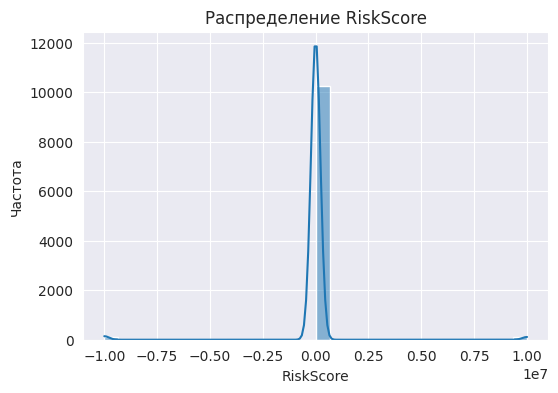

1% квантиль: -9999999.0 99% квантиль: 90.20634537706425


In [2]:
plt.figure(figsize=(6,4))
sns.histplot(df_train["RiskScore"], bins=30, kde=True)
plt.title("Распределение RiskScore")
plt.xlabel("RiskScore")
plt.ylabel("Частота")
plt.show()

q_low, q_high = df_train["RiskScore"].quantile([0.01, 0.99])
print("1% квантиль:", q_low, "99% квантиль:", q_high)


### Уберем из данных шумы и null

In [3]:
def clean_data(df_train, df_test, target="RiskScore"):
    import numpy as np

    # --- Категориальные ---
    cat_cols = df_train.select_dtypes(include="object").columns
    for col in cat_cols:
        df_train[col] = df_train[col].fillna("Unknown")
        df_test[col] = df_test[col].fillna("Unknown")

    # --- Числовые ---
    num_cols = df_train.select_dtypes(include="number").columns.drop(target, errors="ignore")
    for col in num_cols:
        median = df_train[col].median()
        df_train[col] = df_train[col].fillna(median)
        df_test[col] = df_test[col].fillna(median)

        low, high = df_train[col].quantile([0.01, 0.99])
        df_train[col] = df_train[col].clip(lower=low, upper=high)

    # ✅ Фильтрация по таргету — отдельно
    df_train = df_train[
        df_train[target].notna() &
        (df_train[target] >= 0) &
        (df_train[target] <= 100)
    ].reset_index(drop=True)

    return df_train, df_test


df_train, df_test = clean_data(df_train, df_test)



## Корреляционная матрица


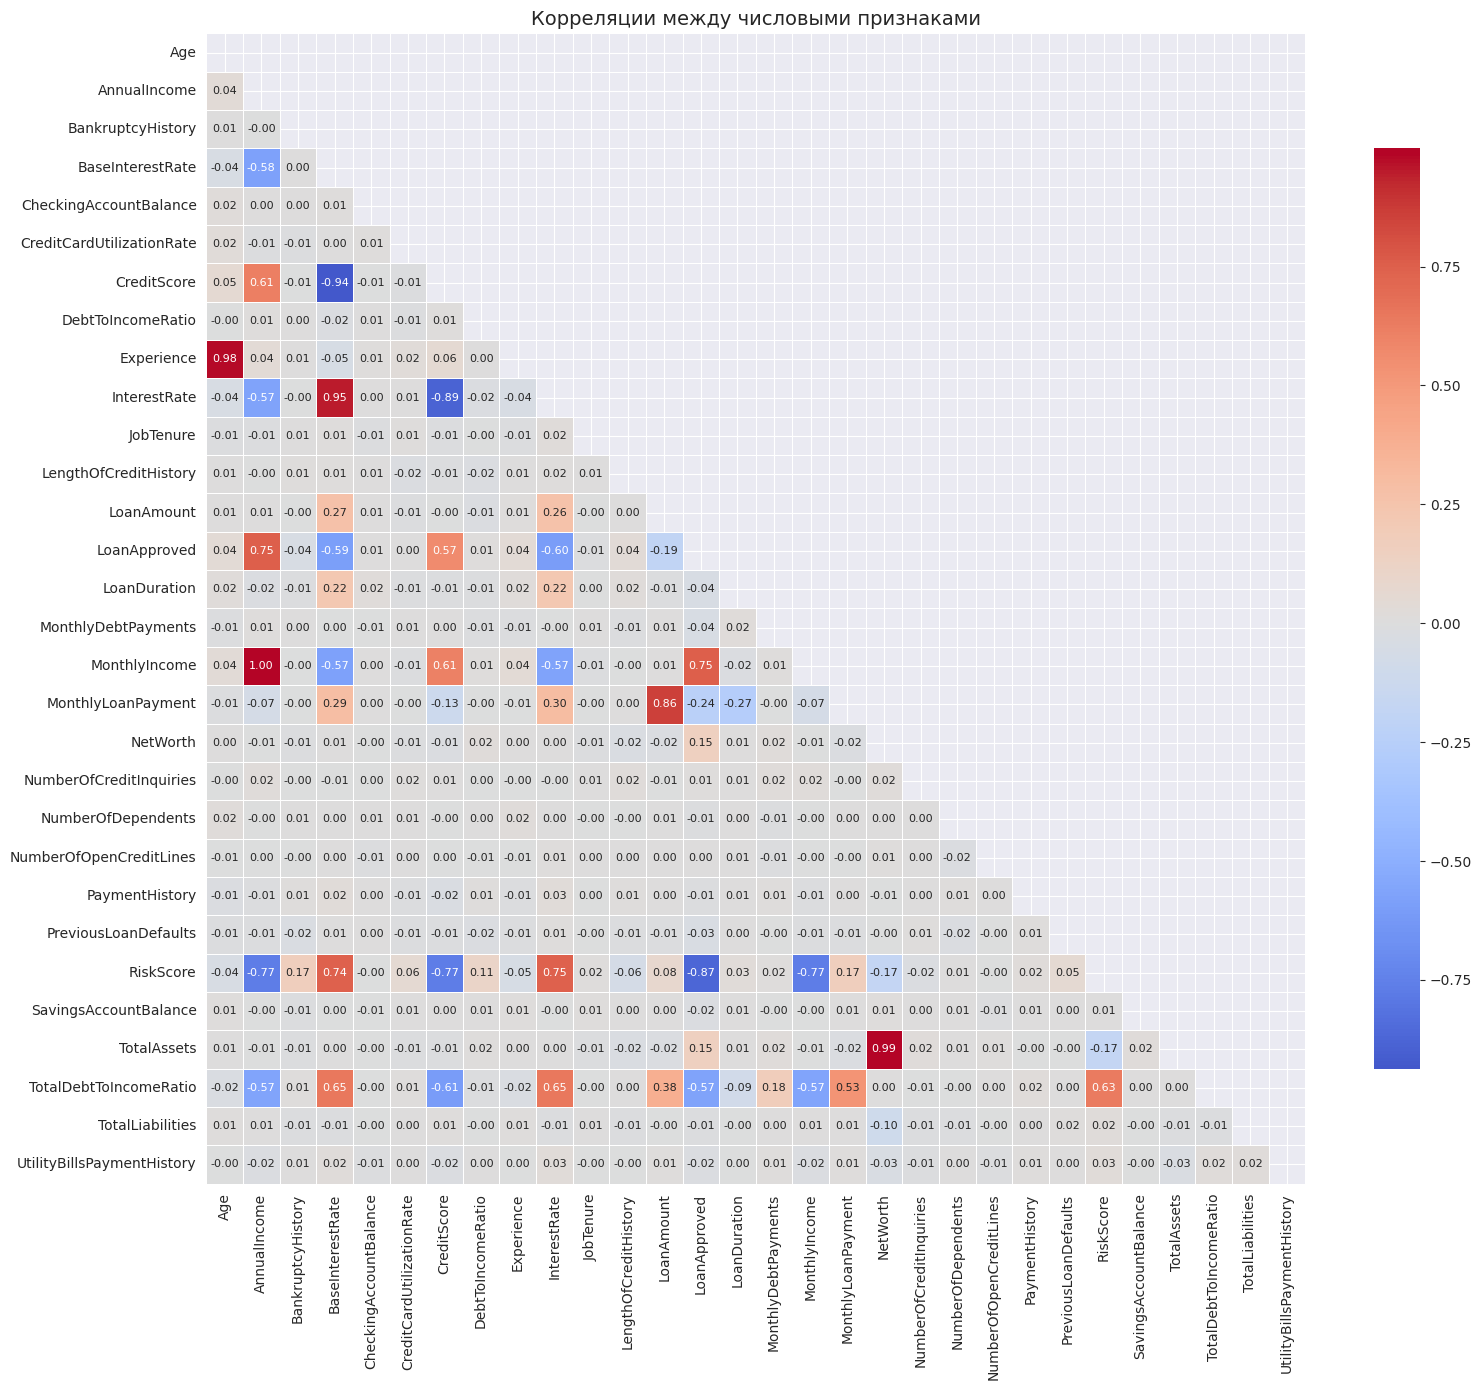

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
corr = df_train[num_cols.union(["RiskScore"])].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,14))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Корреляции между числовыми признаками", fontsize=14)
plt.tight_layout()
plt.show()


In [5]:
num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
corr = df_train[num_cols].corr().abs()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
upper = corr.where(mask)

threshold = 0.1
high_corr_pairs = (
    upper.stack()
         .reset_index()
         .rename(columns={"level_0":"feature_1", "level_1":"feature_2", 0:"corr"})
         .query("corr > @threshold")
         .sort_values("corr", ascending=False)
)

print(high_corr_pairs.to_string(index=False))

             feature_1              feature_2     corr
          AnnualIncome          MonthlyIncome 0.998684
           TotalAssets               NetWorth 0.985674
                   Age             Experience 0.982800
      BaseInterestRate           InterestRate 0.951663
           CreditScore       BaseInterestRate 0.936608
           CreditScore           InterestRate 0.889907
            LoanAmount     MonthlyLoanPayment 0.856782
         MonthlyIncome           LoanApproved 0.754457
          AnnualIncome           LoanApproved 0.753795
          InterestRate TotalDebtToIncomeRatio 0.650102
      BaseInterestRate TotalDebtToIncomeRatio 0.646270
          AnnualIncome            CreditScore 0.613337
           CreditScore          MonthlyIncome 0.612921
           CreditScore TotalDebtToIncomeRatio 0.605617
          InterestRate           LoanApproved 0.603290
      BaseInterestRate           LoanApproved 0.593264
          AnnualIncome       BaseInterestRate 0.575228
         M

In [6]:
num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
print(df_train[num_cols].isna().sum())

Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
NumberOfDependents            0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
Experience                    0
NetWorth                      0
BaseInterestRate              0
InterestRate                  0
MonthlyLoanPayment            0
TotalDebtToIncomeRatio        0
LoanApproved                  0
dtype: int64


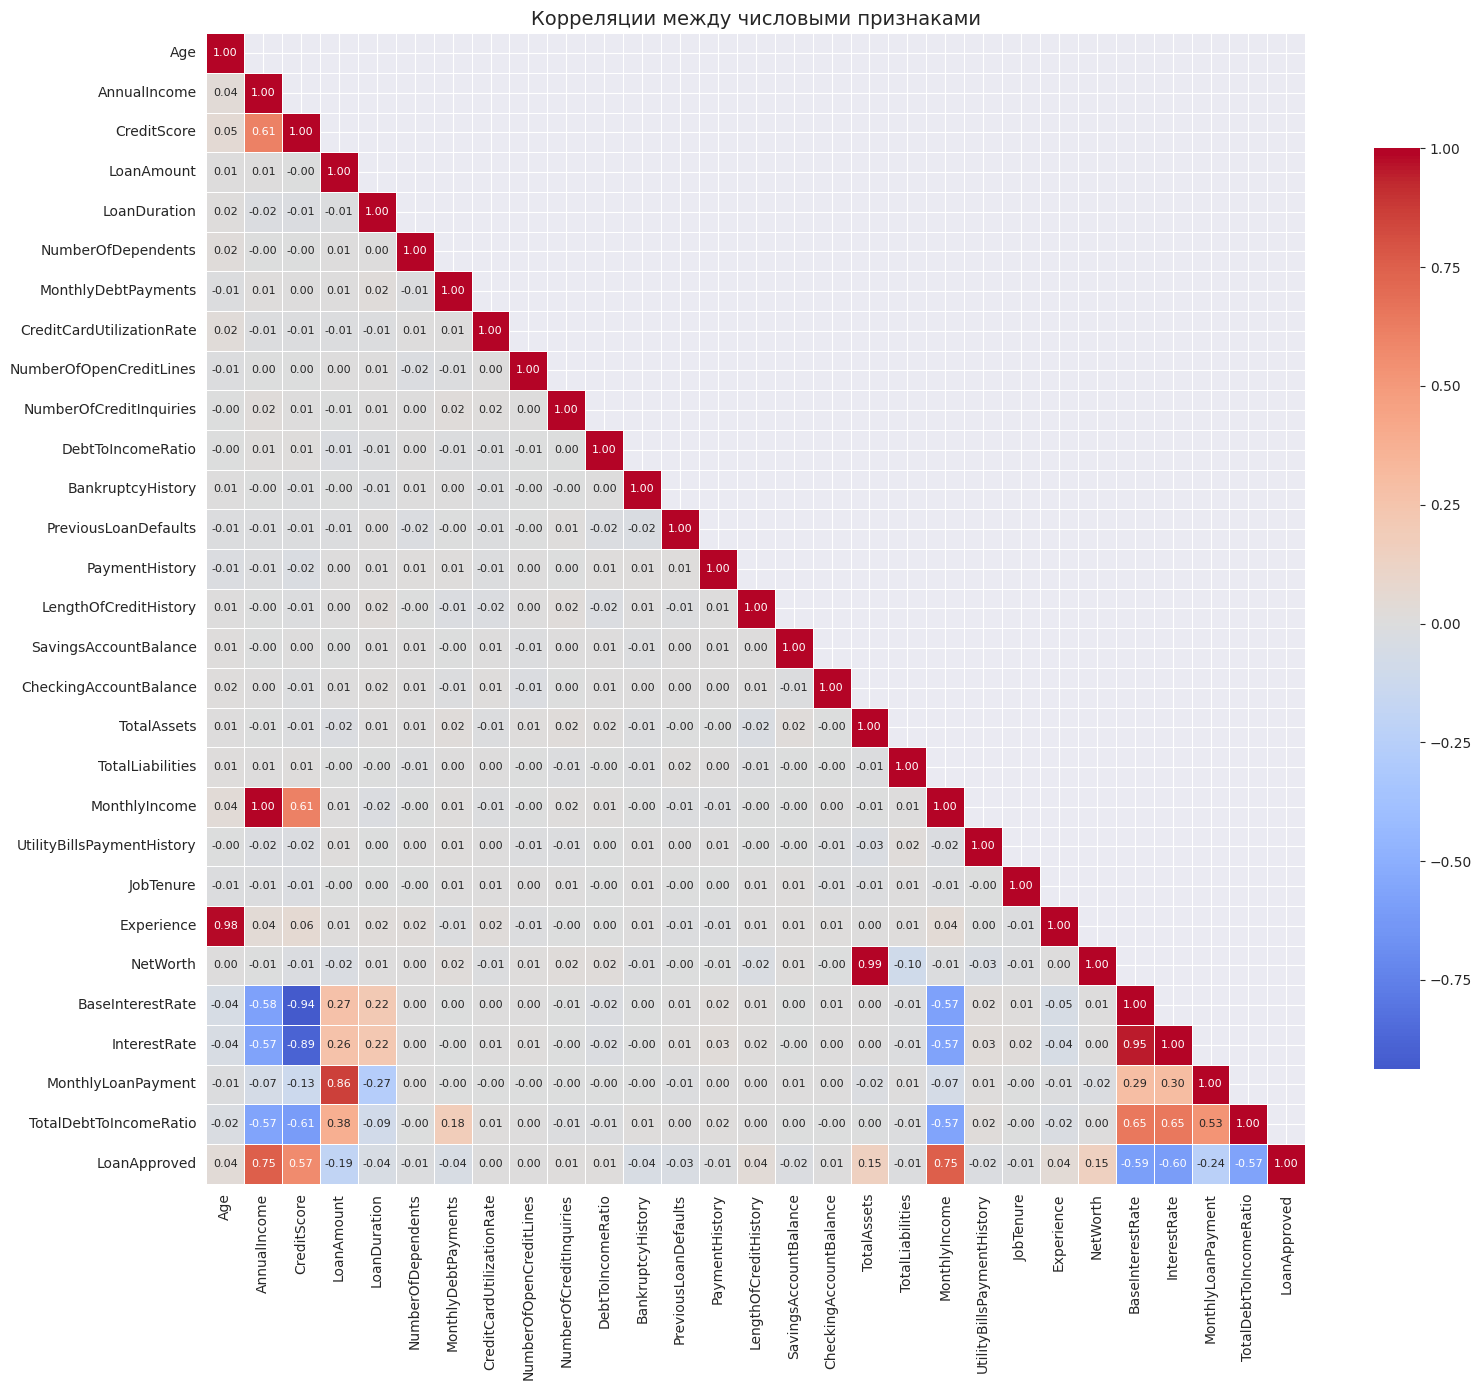

Нужно компонент k = 3 для 95% дисперсии
Собственные числа первых 3 компонентов: [1.54944007e+11 1.30980293e+10 1.27771970e+10]


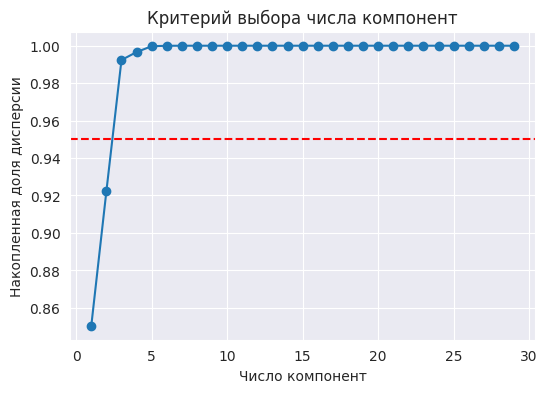

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pca import pca_manual, select_n_components

num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
df_num = df_train[num_cols].fillna(df_train[num_cols].median())
X = df_num.values

corr = df_num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

plt.figure(figsize=(16,14))
sns.heatmap(
    corr,
    mask=mask,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Корреляции между числовыми признаками", fontsize=14)
plt.tight_layout()
plt.show()

k_calc, explained_ratio, cum_ratio = select_n_components(X, variance_threshold=0.95)
print(f"Нужно компонент k = {k_calc} для 95% дисперсии")

X_pca, components, explained_variance = pca_manual(X, n_components=k_calc)
print(f"Собственные числа первых {k_calc} компонентов:", explained_variance)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cum_ratio)+1), cum_ratio, marker="o")
plt.axhline(0.95, color="red", linestyle="--")
plt.xlabel("Число компонент")
plt.ylabel("Накопленная доля дисперсии")
plt.title("Критерий выбора числа компонент")
plt.grid(True)
plt.show()


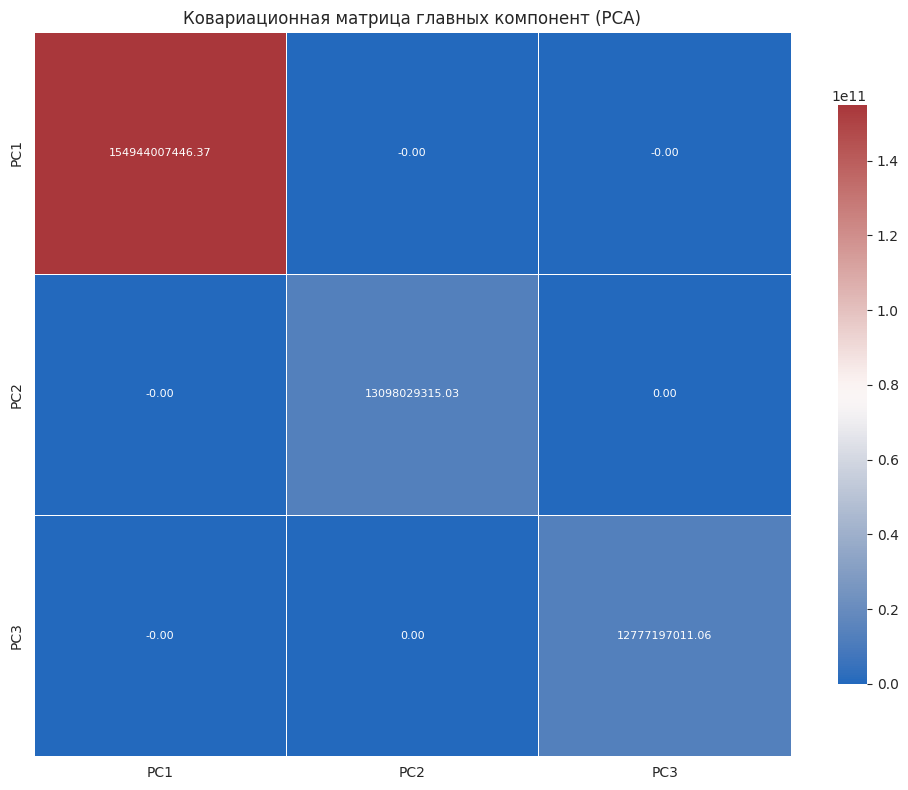

PC1 contribution: 0.8569000333302678
PC2 contribution: 0.072437146434936


In [8]:
# 1. Центрируем результат (по строкам X_pca)
X_pca_c = X_pca - X_pca.mean(axis=0)

# 2. Ковариационная матрица компонент
cov_pca = np.cov(X_pca_c, rowvar=False)

# 3. Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(
    cov_pca,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    xticklabels=[f"PC{i+1}" for i in range(k_calc)],
    yticklabels=[f"PC{i+1}" for i in range(k_calc)],
    linewidths=0.5,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8}
)
plt.title("Ковариационная матрица главных компонент (PCA)")
plt.tight_layout()
plt.show()

total = sum(explained_variance)
print("PC1 contribution:", explained_variance[0] / total)  # ≈ 0.91
print("PC2 contribution:", explained_variance[1] / total)


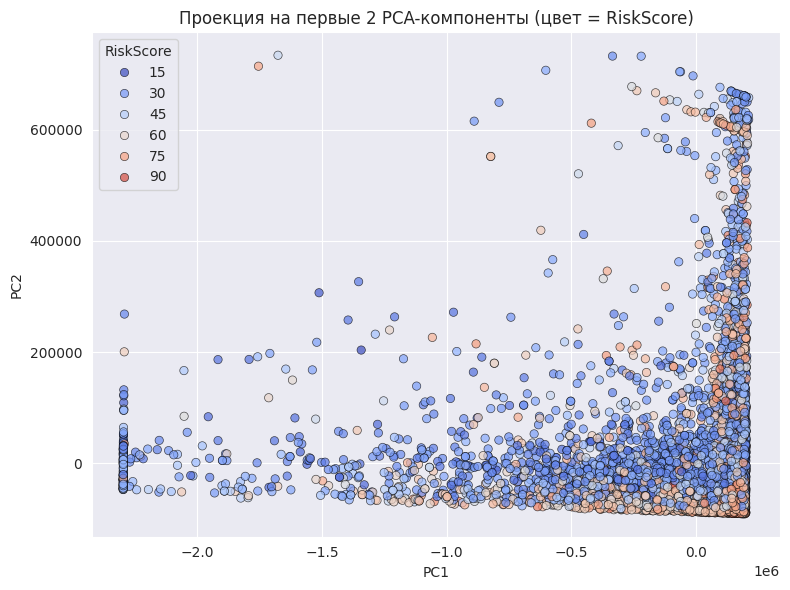

<Axes: xlabel='PC1', ylabel='RiskScore'>

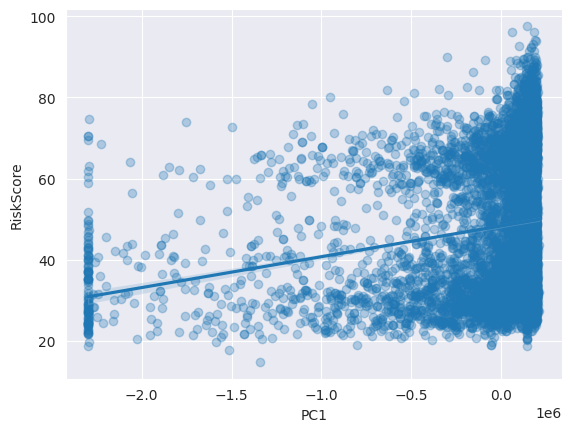

In [9]:
# 1. Возьмём только 2 главные компоненты
pc_df = pd.DataFrame(
    X_pca[:, :2],
    columns=["PC1", "PC2"]
)

# 2. Добавим к ним целевую переменную RiskScore
pc_df["RiskScore"] = df_train["RiskScore"].values

# 3. Визуализация: цвет по значению RiskScore
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pc_df,
    x="PC1",
    y="PC2",
    hue="RiskScore",
    palette="coolwarm",
    edgecolor="k",
    alpha=0.7
)
plt.title("Проекция на первые 2 PCA-компоненты (цвет = RiskScore)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="RiskScore")
plt.grid(True)
plt.tight_layout()
plt.show()

sns.regplot(data=pc_df, x="PC1", y="RiskScore", scatter_kws={"alpha": 0.3})


### Throw away PCA

### Категориальные признаки

In [10]:
q_low, q_high = df_train["RiskScore"].quantile([0.01, 0.99])
df_filtered = df_train[(df_train["RiskScore"] >= q_low) & (df_train["RiskScore"] <= q_high)]
print(f"Оставлено {len(df_filtered)} строк после обрезки выбросов")

Оставлено 10067 строк после обрезки выбросов


In [11]:
cat_cols = df_train.select_dtypes(include=["object", "category"]).columns
df_train[cat_cols].nunique().sort_values()

EmploymentStatus          3
MaritalStatus             4
HomeOwnershipStatus       4
EducationLevel            5
LoanPurpose               6
ApplicationDate        9788
dtype: int64

In [12]:
# Признаки с малым числом уникальных значений
categorical_cols = [
    "EmploymentStatus", "MaritalStatus", "HomeOwnershipStatus",
    "LoanPurpose", "EducationLevel"
]
df_cat = pd.get_dummies(
    df_filtered[categorical_cols],
    drop_first=True,
    prefix=categorical_cols
)
# Объединяем
df_filtered = pd.concat(
    [df_filtered.drop(columns=categorical_cols), df_cat],
    axis=1
)

# Datetime превратим в числовой

In [13]:

# Убедимся, что это datetime
df_filtered["ApplicationDate"] = pd.to_datetime(df_filtered["ApplicationDate"], errors="coerce")

# Извлекаем полезные признаки
df_filtered["AppWeekday"] = df_filtered["ApplicationDate"].dt.weekday  # 0=Пн, 6=Вс
df_filtered["AppMonth"] = df_filtered["ApplicationDate"].dt.month
df_filtered["AppDaysSinceStart"] = (df_filtered["ApplicationDate"] - df_filtered["ApplicationDate"].min()).dt.days

# Удаляем оригинальную дату
df_filtered = df_filtered.drop(columns=["ApplicationDate"])


### Числовые штуки

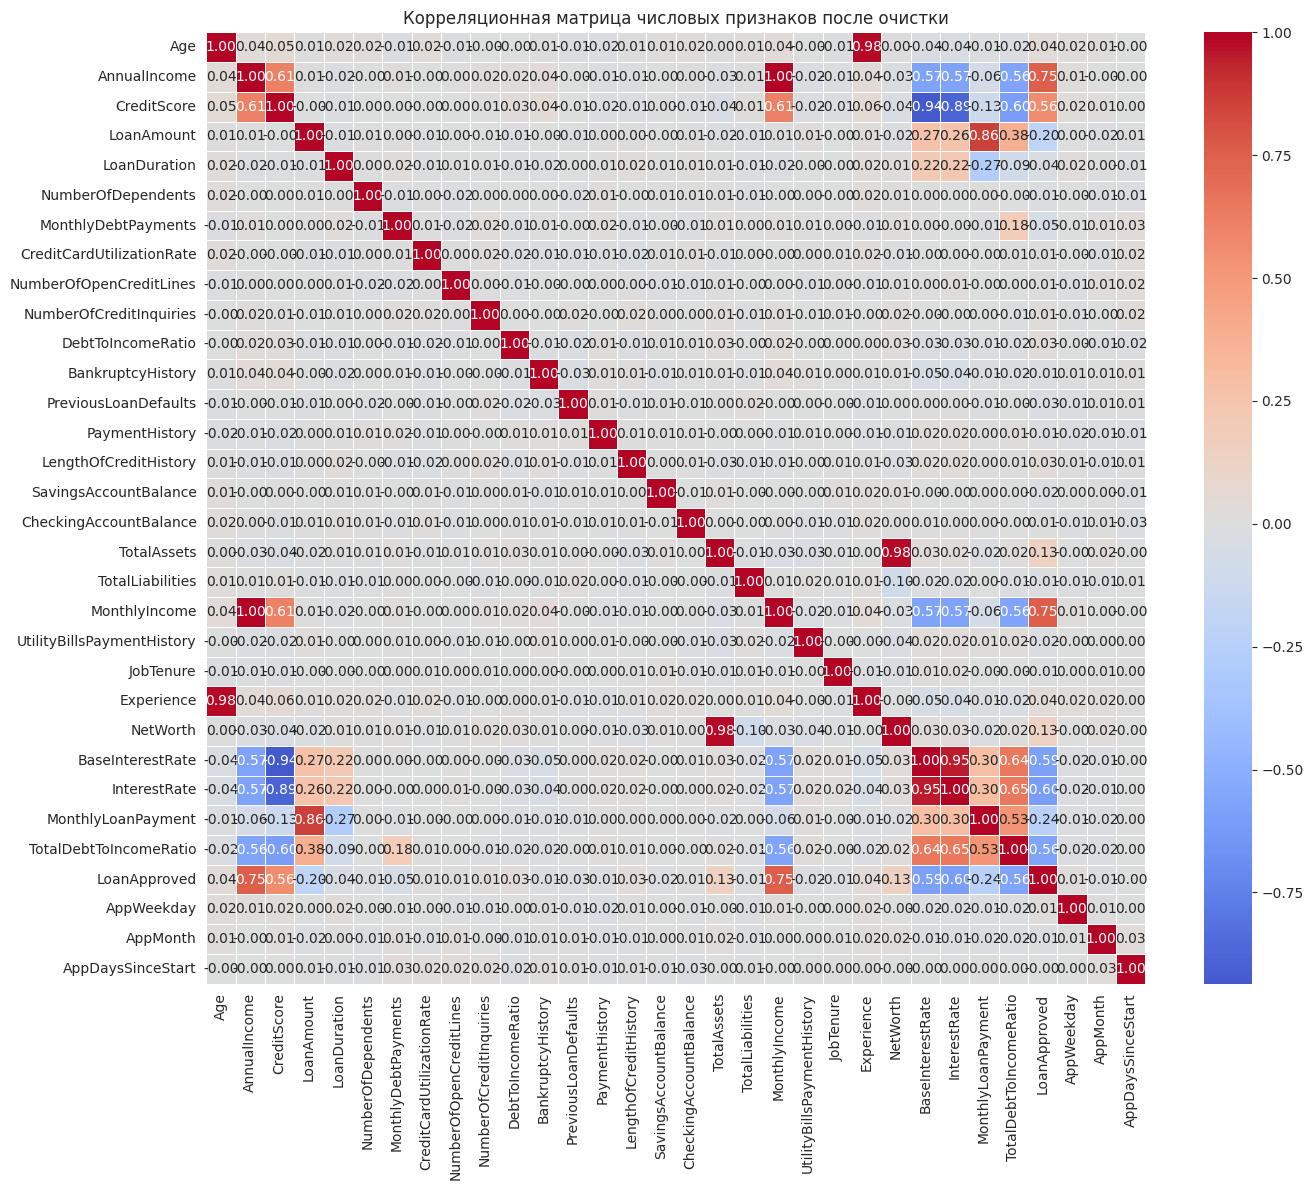

In [14]:
num_cols = df_filtered.select_dtypes(include="number").columns.drop("RiskScore")
df_num = df_filtered[num_cols].copy()

# Заполняем пропуски в числовых только для корреляционного анализа (не изменяя df_filtered)
df_num = df_num.fillna(df_num.median())
plt.figure(figsize=(14,12))
sns.heatmap(
    df_num.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Корреляционная матрица числовых признаков после очистки")
plt.tight_layout()
plt.show()

In [15]:
# Сравнение по корреляции с таргетом
print(df_filtered[["BaseInterestRate", "InterestRate", "RiskScore"]].corr())


                  BaseInterestRate  InterestRate  RiskScore
BaseInterestRate          1.000000      0.951731   0.741627
InterestRate              0.951731      1.000000   0.745436
RiskScore                 0.741627      0.745436   1.000000


In [16]:
print(df_filtered.columns)


Index(['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
       'NumberOfDependents', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
       'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory',
       'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate',
       'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio',
       'LoanApproved', 'RiskScore', 'EmploymentStatus_Self-Employed',
       'EmploymentStatus_Unemployed', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'MaritalStatus_Widowed',
       'HomeOwnershipStatus_Other', 'HomeOwnershipStatus_Own',
       'HomeOwnershipStatus_Rent', 'LoanPurpose_Debt Consolidation',
       'LoanPurpose_Education', 'LoanPurpose_Home', 'Lo

### Объеенил Interest и BaseInterestRate

✅ InterestRate и BaseInterestRate объединены в AvgInterestRate


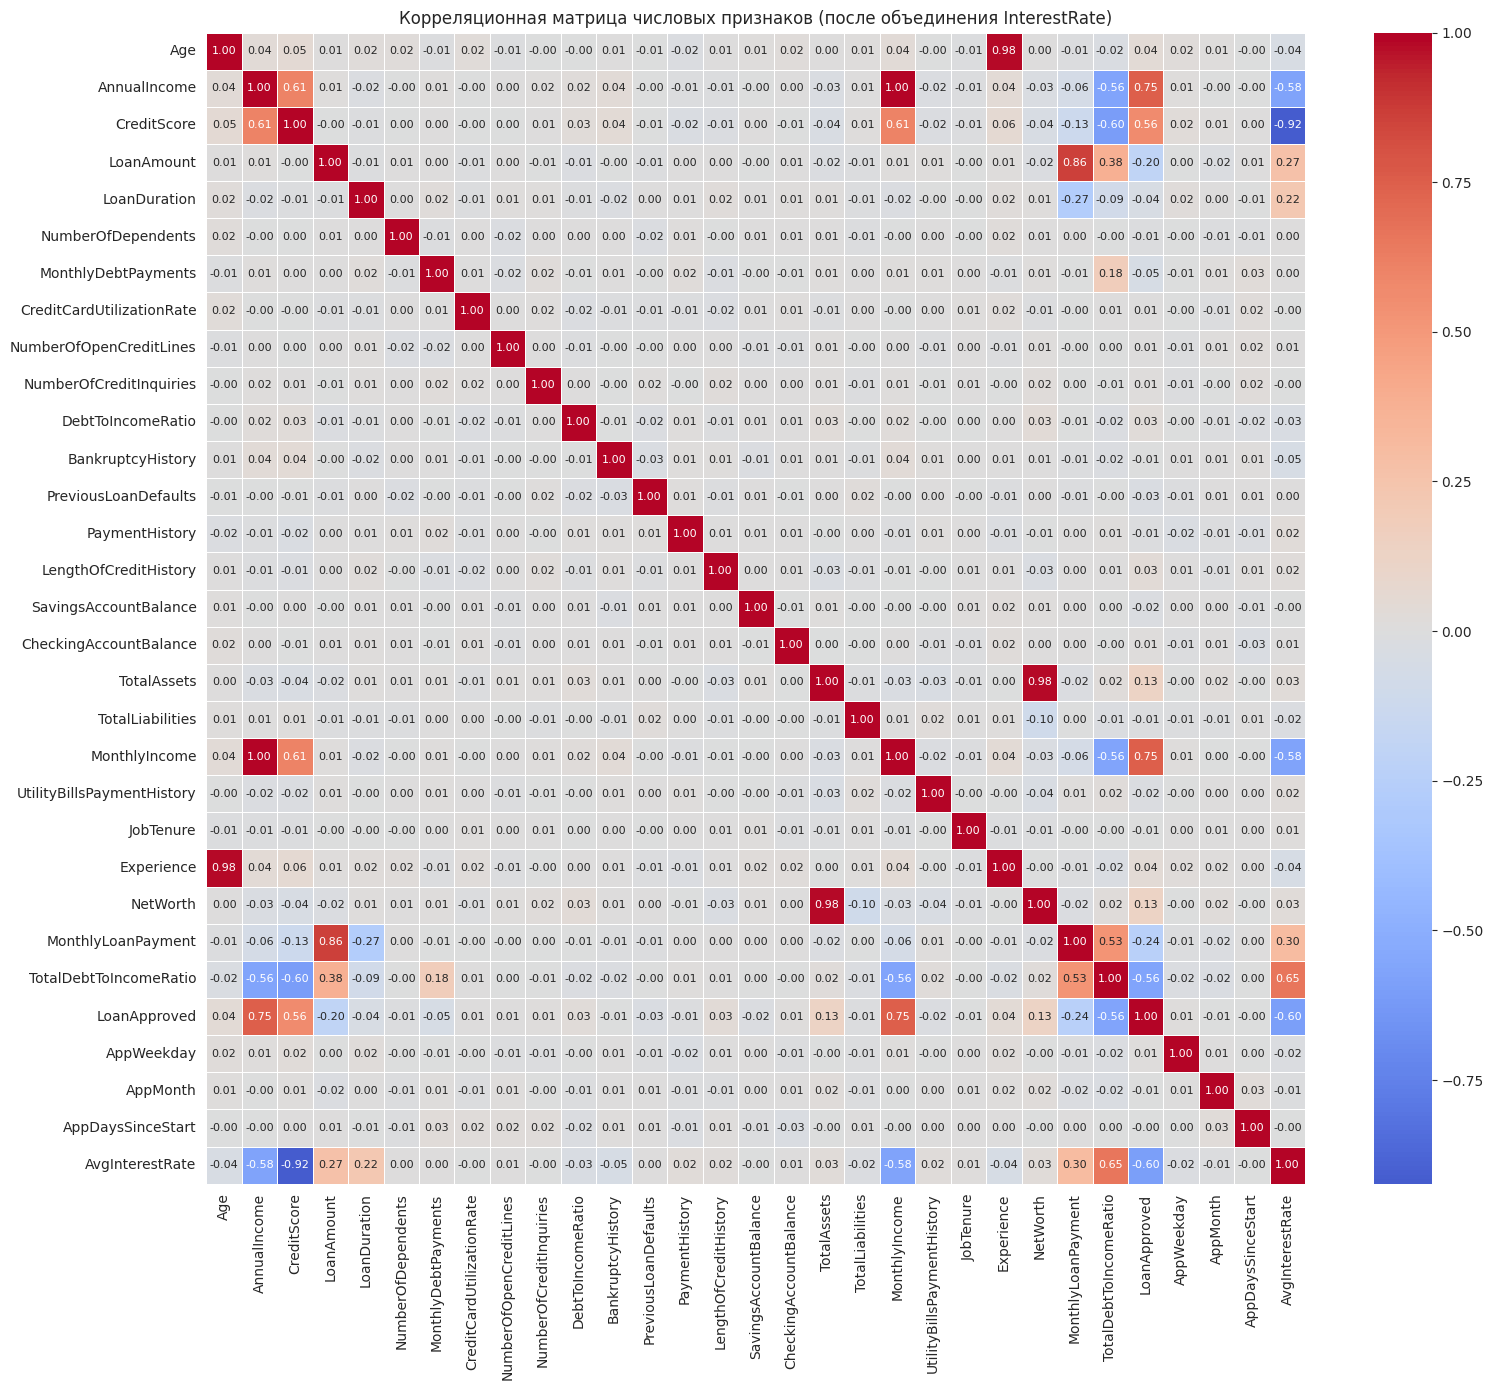

In [17]:
if "InterestRate" in df_filtered.columns and "BaseInterestRate" in df_filtered.columns:
    df_filtered["AvgInterestRate"] = df_filtered[["InterestRate", "BaseInterestRate"]].mean(axis=1)
    df_filtered = df_filtered.drop(columns=["InterestRate", "BaseInterestRate"])
    print("✅ InterestRate и BaseInterestRate объединены в AvgInterestRate")
else:
    print("⚠️ Колонки уже удалены или переименованы. Пропускаем объединение.")


# 3. Перестроим корреляционную матрицу
num_cols = df_filtered.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")
df_num = df_filtered[num_cols].fillna(...)
corr = df_num.corr()


# 4. Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Корреляционная матрица числовых признаков (после объединения InterestRate)")
plt.tight_layout()
plt.show()


### Удаляю Experience и Annual Income MonthlyLoanPayment, TotalAssets

In [18]:
to_remove = []

# Age vs Experience
for col in ["Experience", "AnnualIncome", "TotalAssets", "MonthlyLoanPayment"]:
    if col in df_filtered.columns:
        df_filtered = df_filtered.drop(columns=[col])
        to_remove.append(col)
    if col in df_test.columns:
        df_test = df_test.drop(columns=[col])

print("Удалены дублирующие признаки:", to_remove)


Удалены дублирующие признаки: ['Experience', 'AnnualIncome', 'TotalAssets', 'MonthlyLoanPayment']


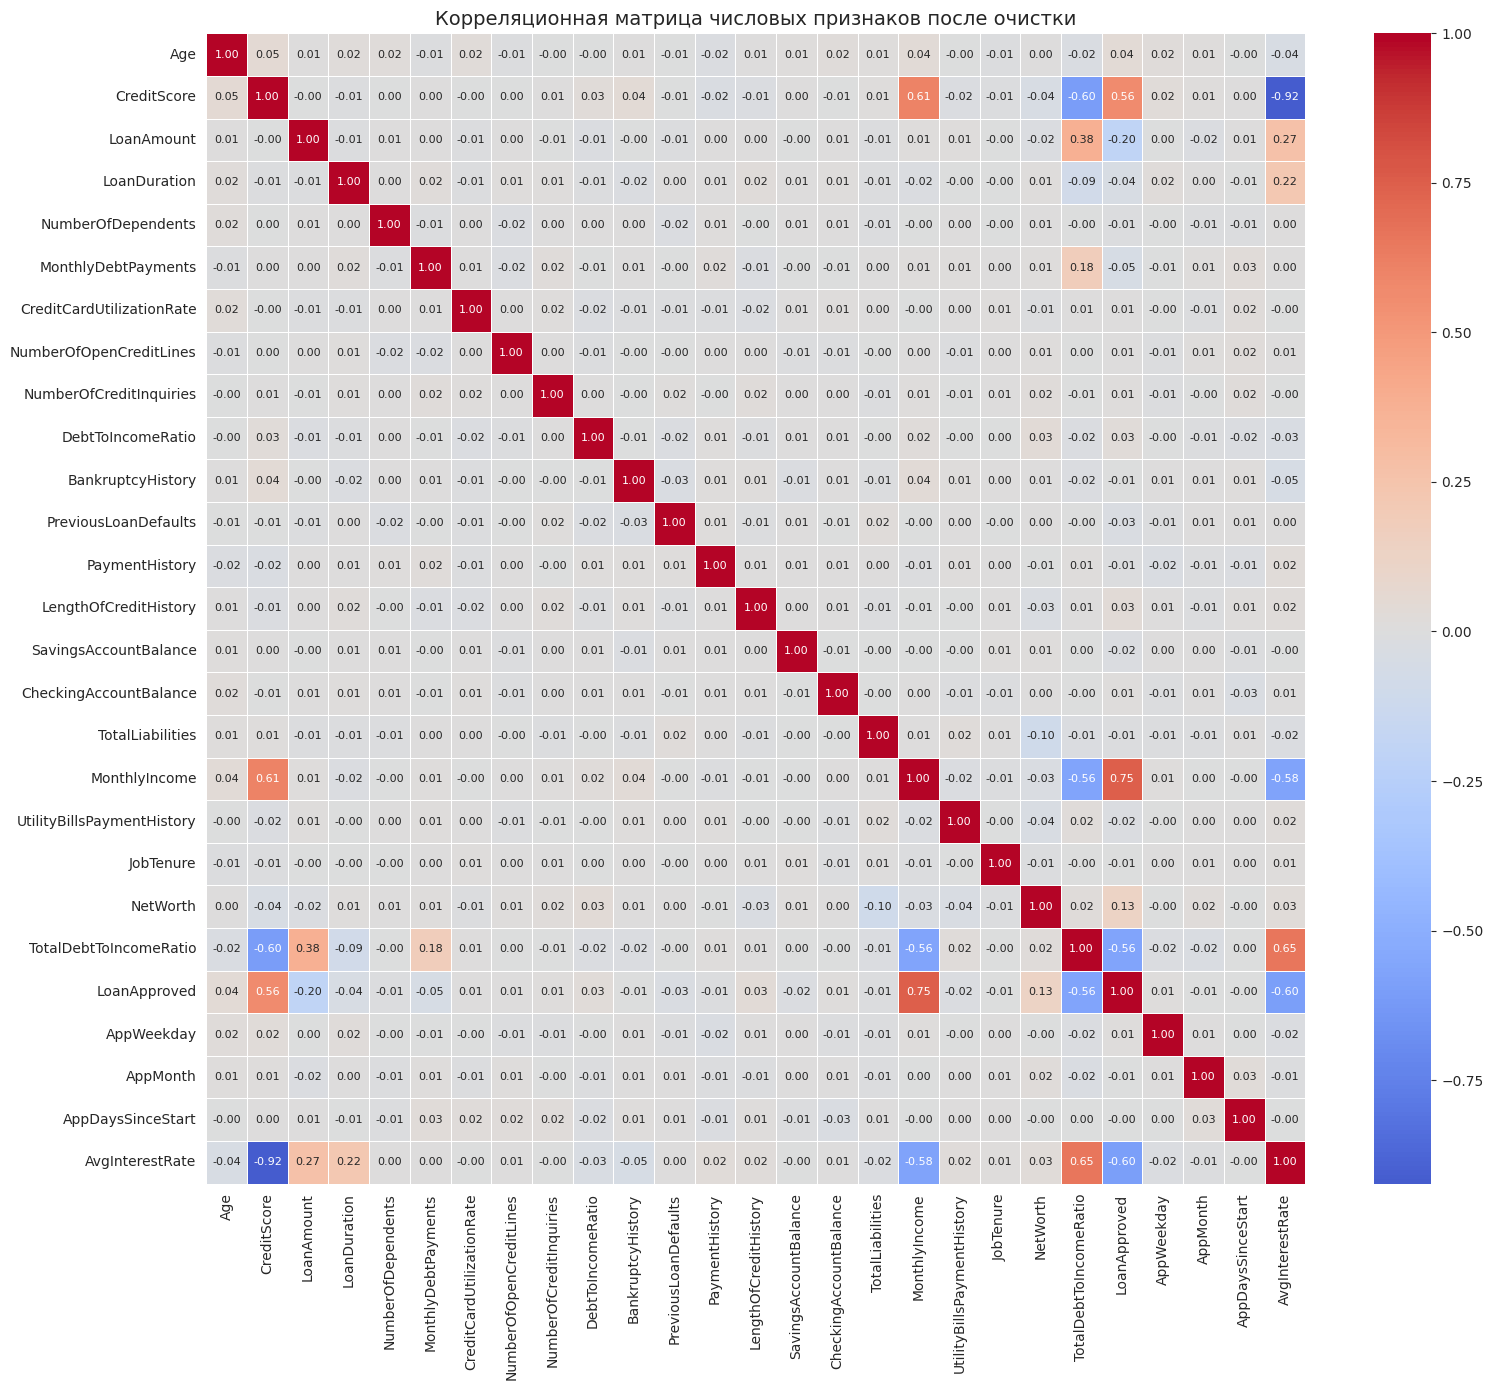

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Собираем все числовые колонки, кроме RiskScore
num_cols = df_filtered.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")
df_num = df_filtered[num_cols].fillna(df_filtered[num_cols].median())

# 4. Корреляционная матрица
corr = df_num.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="coolwarm", center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Корреляционная матрица числовых признаков после очистки", fontsize=14)
plt.tight_layout()
plt.show()


### Гистограммы всех числовых признаков

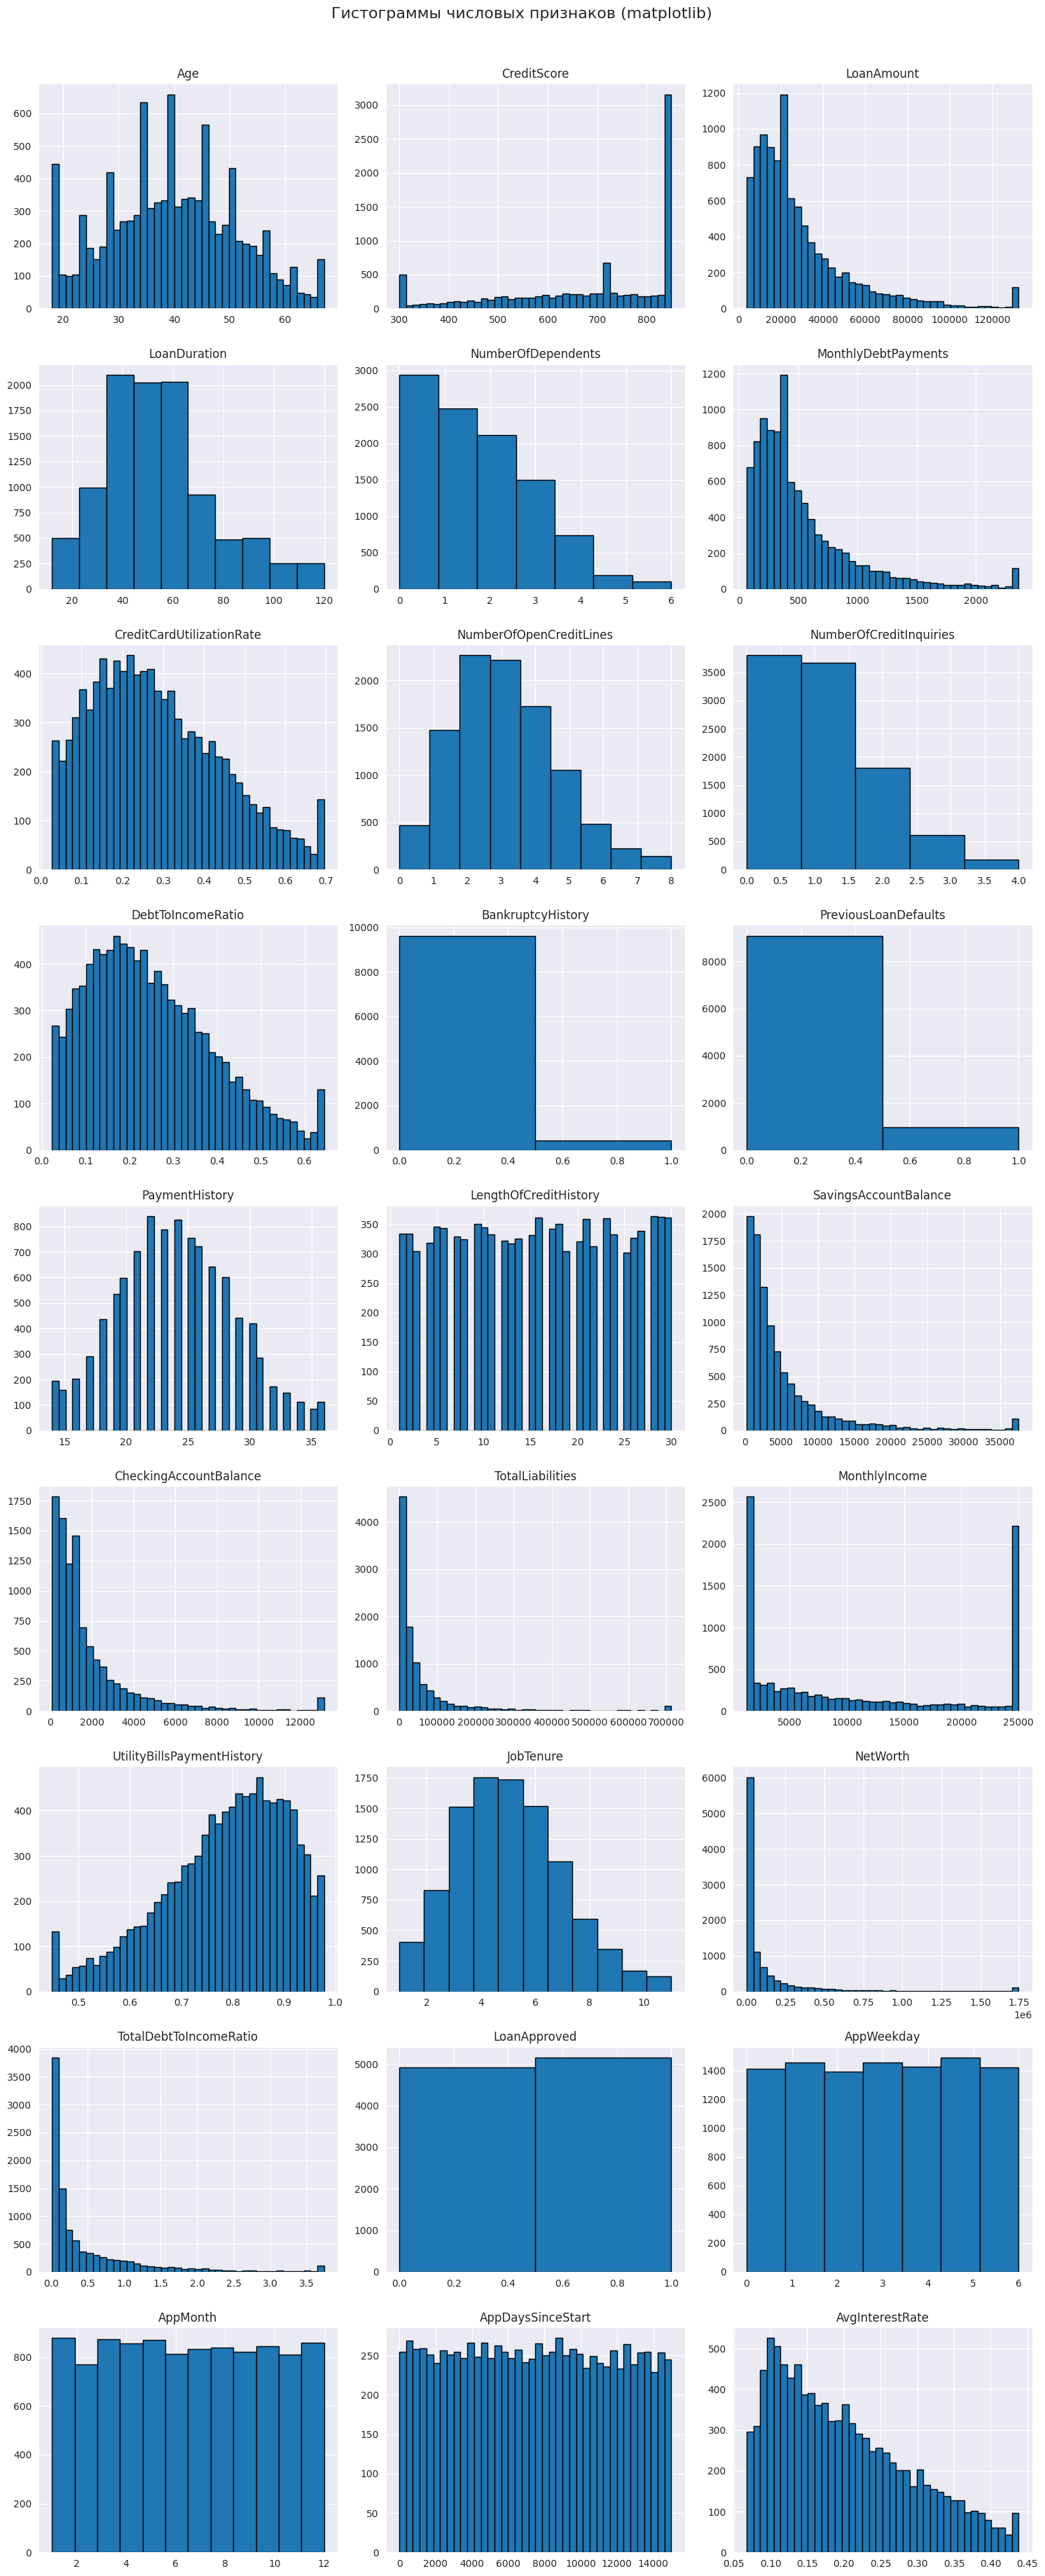

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Числовые признаки без таргета
num_cols = df_filtered.select_dtypes(include="number").columns.drop("RiskScore")

n = len(num_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(nrows, ncols, i)
    data = df_filtered[col].dropna()

    bins = 40 if data.nunique() > 20 else data.nunique()
    plt.hist(data, bins=bins, edgecolor='black')

    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Гистограммы числовых признаков (matplotlib)", fontsize=16, y=1.02)
plt.show()


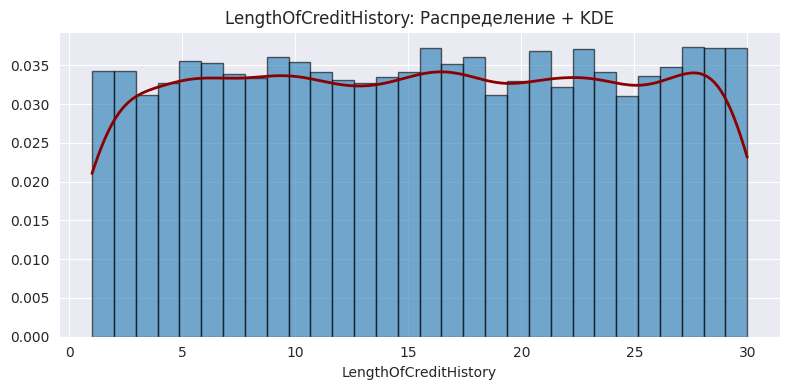

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

data = df_filtered["LengthOfCreditHistory"].dropna()

plt.figure(figsize=(8, 4))

# Гистограмма
plt.hist(data, bins=30, edgecolor='black', alpha=0.6, density=True)

# KDE
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 200)
plt.plot(x_vals, kde(x_vals), color='darkred', linewidth=2)

plt.title("LengthOfCreditHistory: Распределение + KDE")
plt.xlabel("LengthOfCreditHistory")
plt.grid(True)
plt.tight_layout()
plt.show()


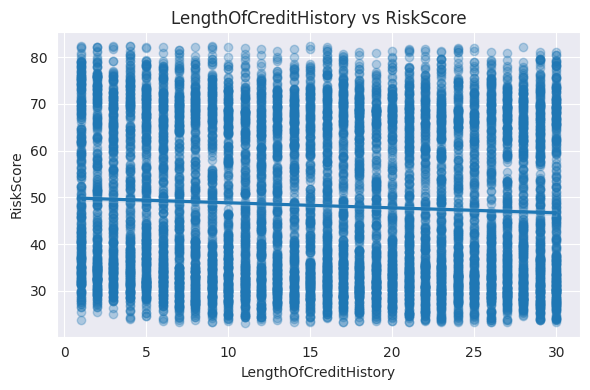

In [22]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.regplot(data=df_filtered, x="LengthOfCreditHistory", y="RiskScore", scatter_kws={"alpha": 0.3})
plt.title("LengthOfCreditHistory vs RiskScore")
plt.grid(True)
plt.tight_layout()
plt.show()


### Выкидываем LengthOfCreditHistory

In [23]:
df_filtered = df_filtered.drop(columns=["LengthOfCreditHistory"])
print("🗑 Удалено: LengthOfCreditHistory — равномерное, не влияет на RiskScore")


🗑 Удалено: LengthOfCreditHistory — равномерное, не влияет на RiskScore


### AGE
Он нормально распределен в бины в 5 лет - оставляем

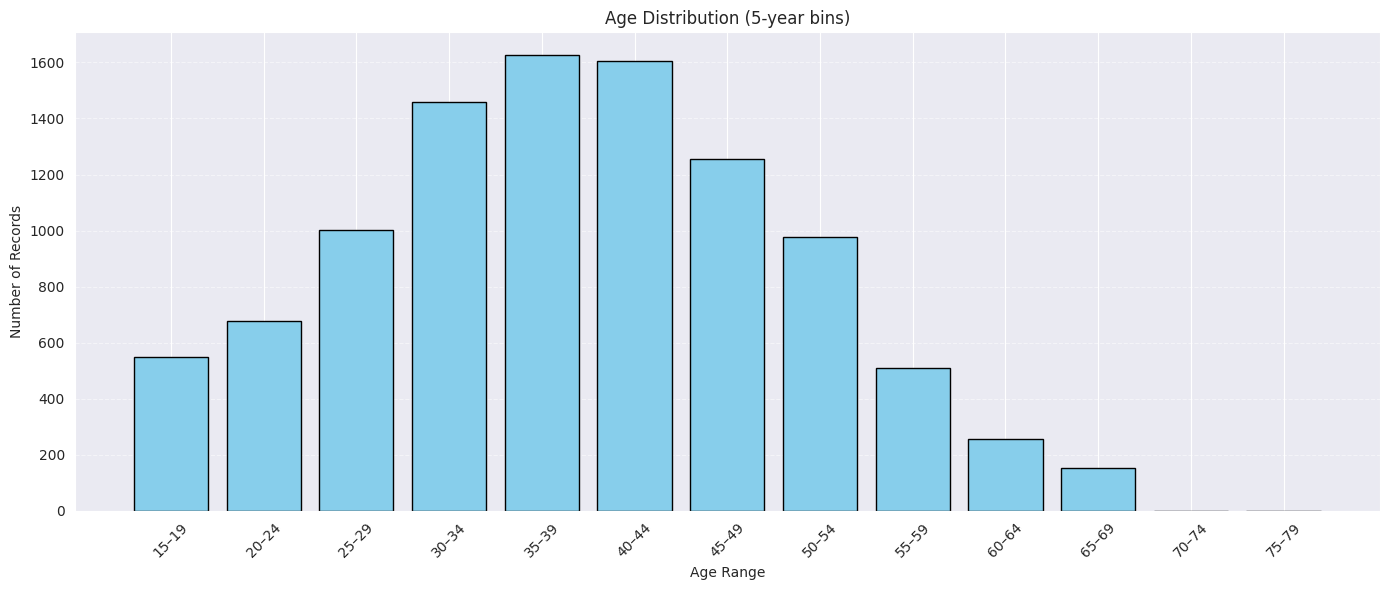

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Обрезаем пропуски
ages = df_filtered["Age"].dropna()

# 2. Разбиваем на интервалы (бины каждые 5 лет)
bins = pd.cut(ages, bins=range(15, 85, 5))
counts = bins.value_counts().sort_index()

# 3. Формируем подписи вида '20–24'
labels = [f"{int(i.left)}–{int(i.right) - 1}" for i in counts.index]

# 4. Рисуем
plt.figure(figsize=(14, 6))
plt.bar(labels, counts.values, color="skyblue", edgecolor="black")

plt.xticks(rotation=45)
plt.xlabel("Age Range")
plt.ylabel("Number of Records")
plt.title("Age Distribution (5-year bins)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Обработка данных

### Делаем фичу

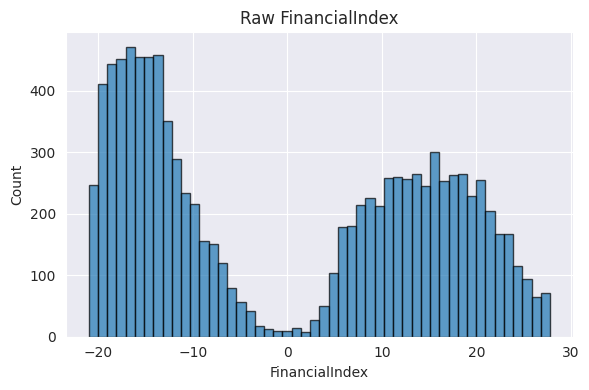

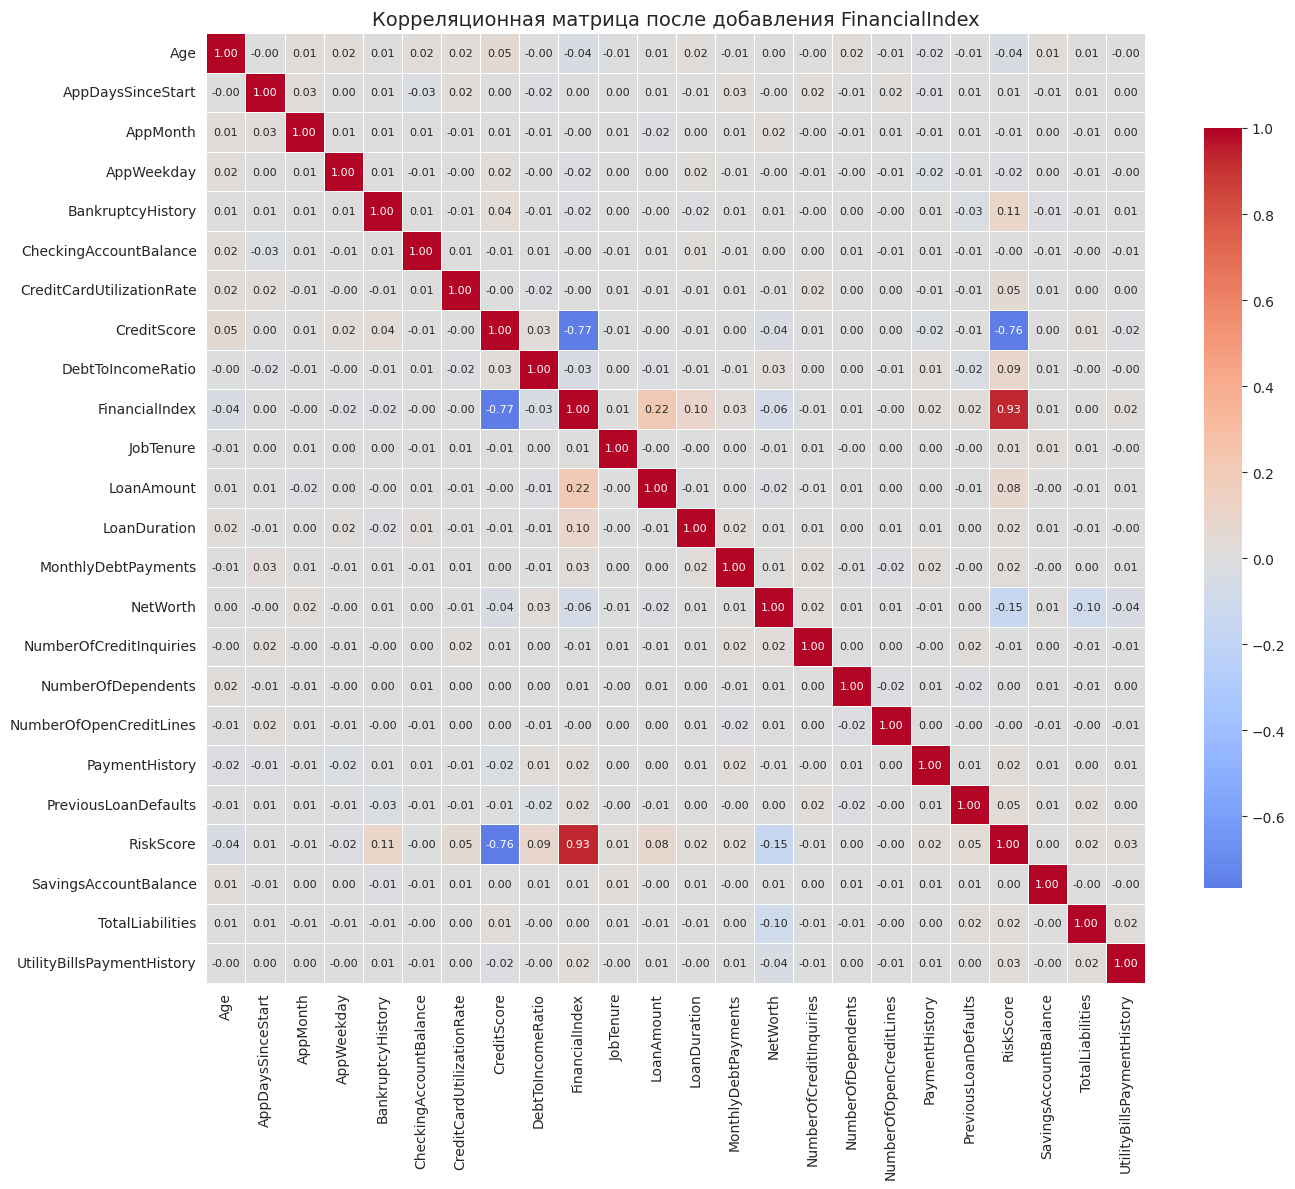

In [25]:
import numpy as np
import pandas as pd
from linear_regression import LinearRegressionManual
from normalization import normalize_zscore

# --- Шаг 1: признаки для индекса
financial_cols = ["MonthlyIncome", "TotalDebtToIncomeRatio", "AvgInterestRate", "LoanApproved"]
X_raw = df_filtered[financial_cols].copy()
X_raw = X_raw.fillna(X_raw.median())  # защита от NaN

# --- Шаг 2: нормализация Z-score
X_norm, stats = normalize_zscore(X_raw)  # stats можно сохранить для теста

# --- Шаг 3: обучение линейной модели
y = df_filtered["RiskScore"].values
model = LinearRegressionManual(method="analytic")
model.fit(X_norm, y)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from normalization import normalize_zscore

# --- Шаг 1: исходные фичи и заполнение пропусков
financial_cols = ["MonthlyIncome", "TotalDebtToIncomeRatio", "AvgInterestRate", "LoanApproved"]
X_raw = df_filtered[financial_cols].copy()
X_raw = X_raw.fillna(X_raw.median())

# --- Шаг 2: нормализация Z-score (повторяем для согласованности)
X_norm, stats = normalize_zscore(X_raw)

# --- Шаг 3: пересоздаём weights на основе уже обученной модели
# (или можно было сохранить их сразу после fit)
weights = dict(zip(financial_cols, model.coef_))

# --- Шаг 4: считаем FinancialIndex на тех же нормализованных данных
df_filtered["FinancialIndex"] = np.dot(X_norm, model.coef_)

# new
threshold = df_filtered["FinancialIndex"].median()

# --- Шаг 5: визуализируем «сырое» распределение
plt.figure(figsize=(6, 4))
df_filtered["FinancialIndex"].hist(bins=50, edgecolor='black', alpha=0.7)
plt.title("Raw FinancialIndex")
plt.xlabel("FinancialIndex")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# (Поскольку распределение близко к нормальному, логарифмировать не обязательно)

# --- Шаг 6: удаляем исходные признаки
df_filtered.drop(columns=financial_cols, inplace=True, errors="ignore")

# --- Шаг 7: строим окончательную корреляционную матрицу
num_cols = df_filtered.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")
corr = df_filtered[num_cols.union(["RiskScore", "FinancialIndex"])].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="coolwarm", center=0,
    linewidths=0.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Корреляционная матрица после добавления FinancialIndex", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from encoders import one_hot_encode

# --- 1. Настройка признаков ---
log_features = [
    "LoanAmount", "MonthlyDebtPayments", "NumberOfDependents",
    "SavingsAccountBalance", "CheckingAccountBalance",
    "TotalAssets", "TotalLiabilities", "NetWorth",
    "TotalDebtToIncomeRatio", "AvgInterestRate"
]

bin_features = {
    "CreditScore": [300, 600, 700, 750, 800, 850],
    "MonthlyIncome": [0, 3000, 6000, 10000, 20000, 50000, 100000]
}

# --- 2. Функция трансформации ---
def transform_features(df, log_features, bin_features, drop_first=True, return_transformed_df=False):
    df = df.copy()
    transformed_parts = []

    # 1. log1p
    for col in log_features:
        if col in df.columns:
            df[col] = df[col].clip(lower=0)
            df[col + "_log"] = np.log1p(df[col])
            transformed_parts.append(df[[col + "_log"]])

    # 2. binning + one-hot
    for col, bins in bin_features.items():
        if col in df.columns:
            binned = pd.cut(df[col], bins=bins, include_lowest=True)
            binned_encoded = pd.get_dummies(binned, prefix=col, drop_first=drop_first)
            transformed_parts.append(binned_encoded)

    # 3. Остальные числовые признаки (без RiskScore)
    numeric_cols = df.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")
    skip_cols = set(log_features + list(bin_features.keys()))
    remaining = [col for col in numeric_cols if col not in skip_cols]
    transformed_parts.append(df[remaining])

    # 4. Финальный X
    X_final = pd.concat(transformed_parts, axis=1)

    # 5. Удаление оригинальных признаков, если нужно
    cols_to_remove = log_features + list(bin_features.keys())
    df.drop(columns=[col for col in cols_to_remove if col in df.columns], inplace=True)

    if return_transformed_df:
        return X_final, df
    else:
        return X_final

# --- 3. Применение трансформации + сохранение log'ов и binned признаков в df_train ---
X_prepared, df_transformed = transform_features(df_train, log_features, bin_features, return_transformed_df=True)

# --- 4. Визуализация по обработанному df ---
num_cols = df_transformed.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")

n = len(num_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(nrows, ncols, i)
    data = df_transformed[col].dropna()

    bins = 40 if data.nunique() > 20 else data.nunique()
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.6, density=True)

    if data.nunique() > 10:
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 200)
        plt.plot(x_vals, kde(x_vals), color='darkred', linewidth=2)

    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📊 Распределения после трансформации", fontsize=16, y=1.02)
plt.show()


### Заметим что NumberOfCreditInquiries  NumberOfDependents_log - странные отменим у них log

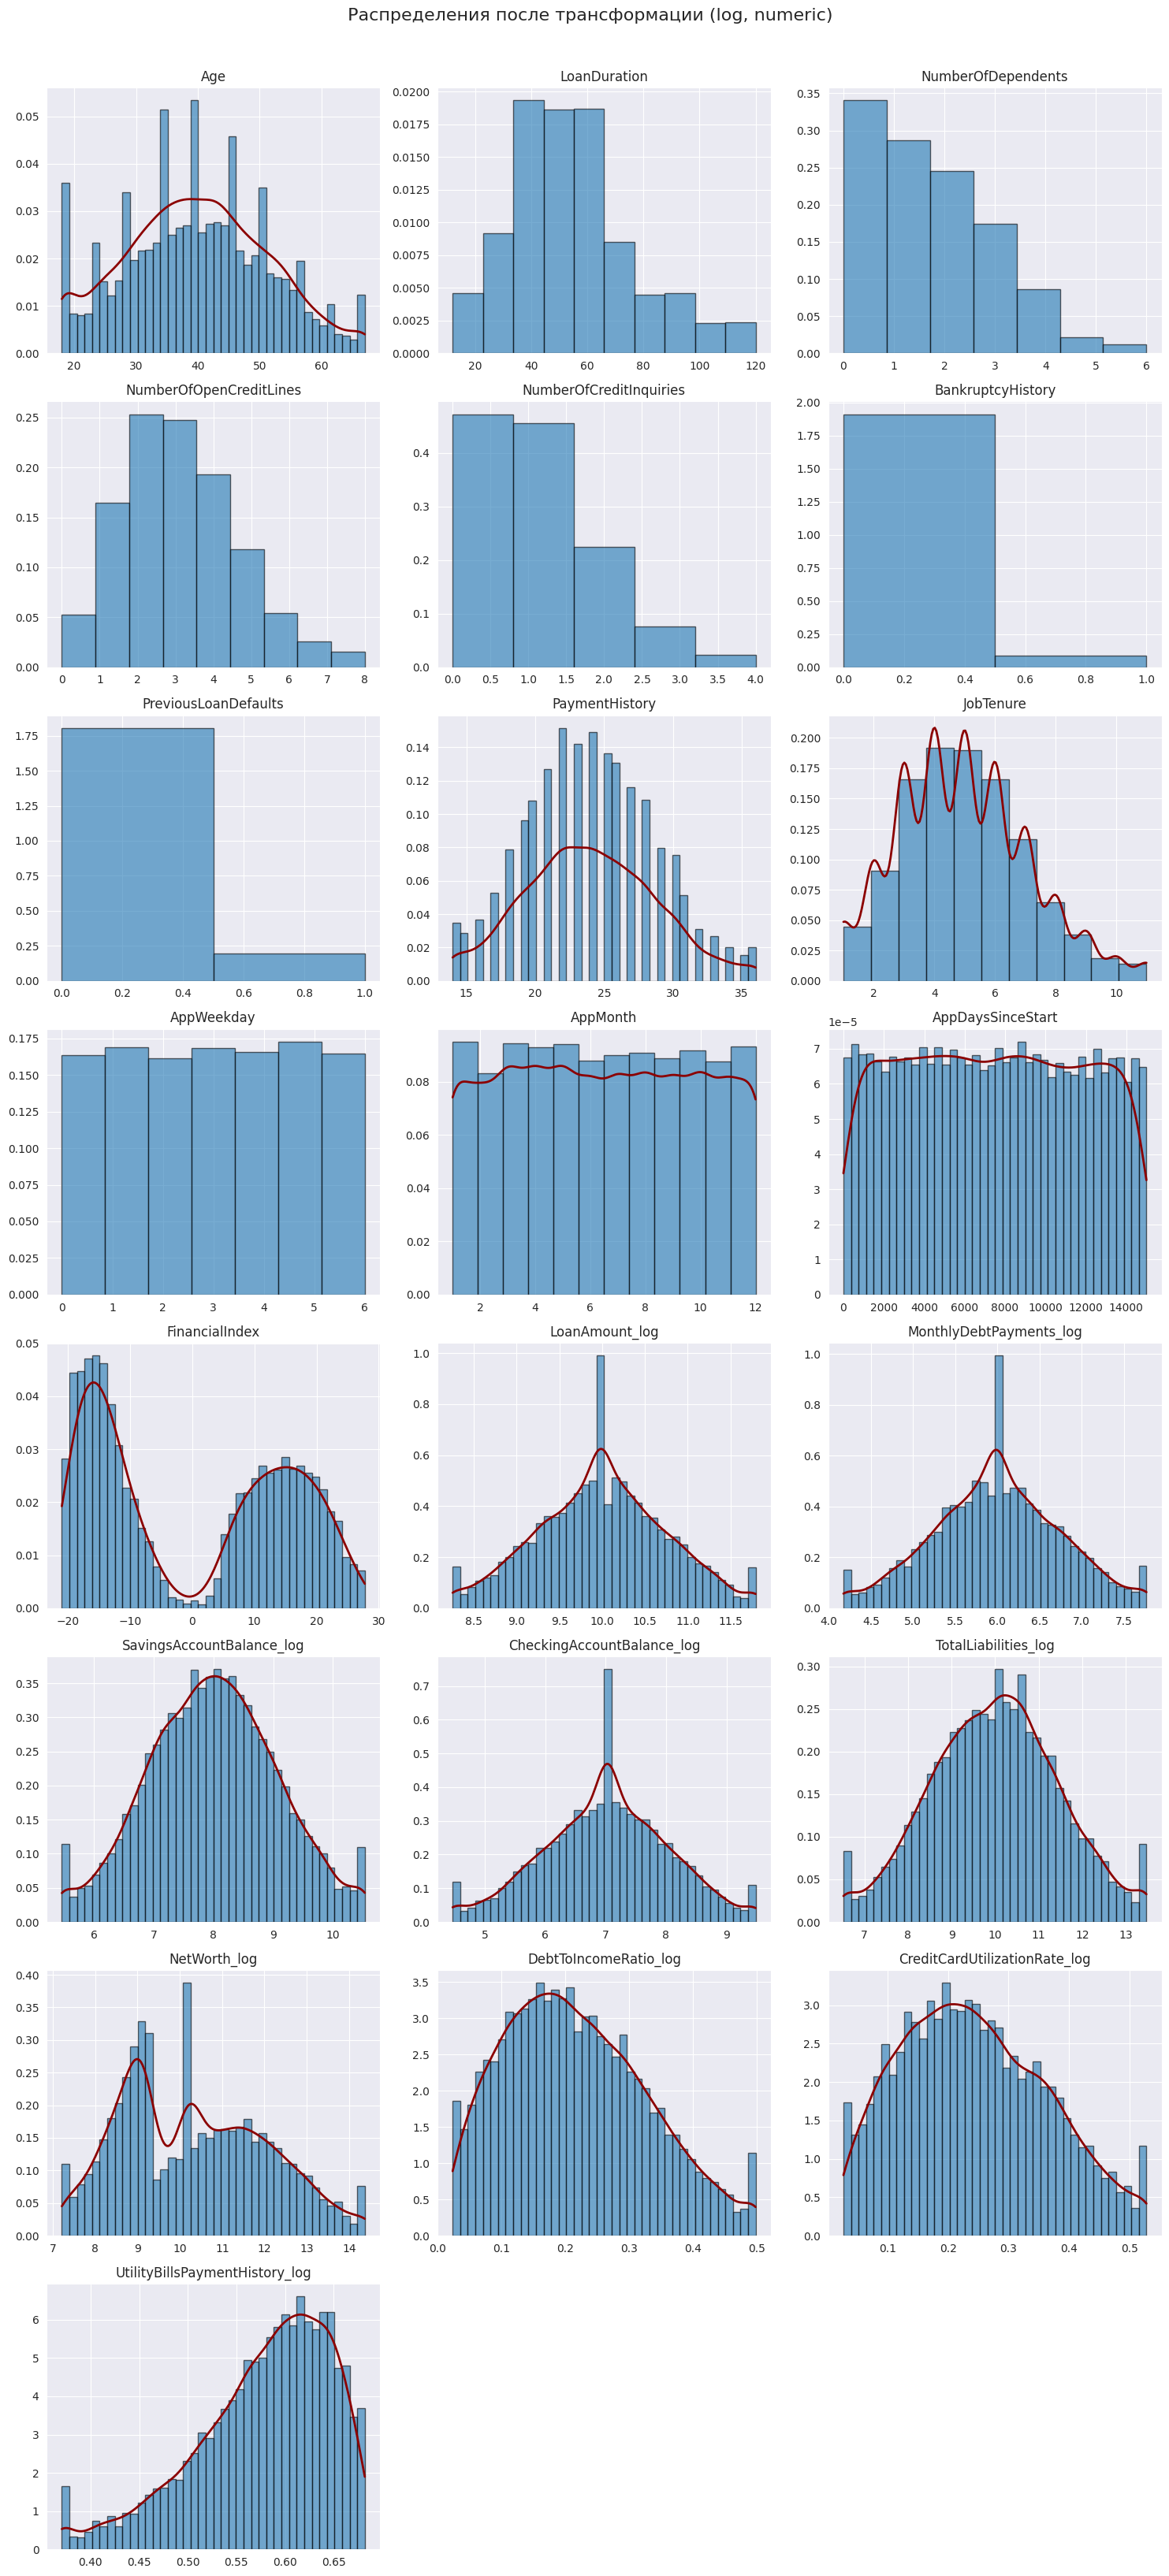

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from encoders import one_hot_encode

# --- 1. Настройка признаков ---
log_features = [
    "LoanAmount", "MonthlyDebtPayments",
    "SavingsAccountBalance", "CheckingAccountBalance",
    "TotalAssets", "TotalLiabilities", "NetWorth",
    "TotalDebtToIncomeRatio", "AvgInterestRate",
    "DebtToIncomeRatio", "CreditCardUtilizationRate",
    "UtilityBillsPaymentHistory"
]  # <- убран NumberOfDependents

bin_features = {
    "CreditScore": [300, 600, 700, 750, 800, 850],
    "MonthlyIncome": [0, 3000, 6000, 10000, 20000, 50000, 100000]
}

# --- 2. Функция трансформации ---
def transform_features(df, log_features, bin_features, drop_first=True, return_transformed_df=False):
    df = df.copy()
    transformed_parts = []

    # 1. log1p
    for col in log_features:
        if col in df.columns:
            df[col] = df[col].clip(lower=0)
            df[col + "_log"] = np.log1p(df[col])
            transformed_parts.append(df[[col + "_log"]])

    # 2. binning + one-hot
    for col, bins in bin_features.items():
        if col in df.columns:
            binned = pd.cut(df[col], bins=bins, include_lowest=True)
            binned_encoded = pd.get_dummies(binned, prefix=col, drop_first=drop_first)
            transformed_parts.append(binned_encoded)

    # 3. Остальные числовые признаки (без RiskScore)
    numeric_cols = df.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")
    skip_cols = set(log_features + list(bin_features.keys()))
    remaining = [col for col in numeric_cols if col not in skip_cols]
    transformed_parts.append(df[remaining])

    # 4. Финальный X
    X_final = pd.concat(transformed_parts, axis=1)

    # 5. Удаление оригинальных признаков
    cols_to_remove = log_features + list(bin_features.keys())
    df.drop(columns=[col for col in cols_to_remove if col in df.columns], inplace=True)

    if return_transformed_df:
        return X_final, df
    else:
        return X_final

# --- 3. Применение трансформации + сохранение log'ов и binned признаков в df_train ---
X_prepared, df_filtered = transform_features(df_filtered, log_features, bin_features, return_transformed_df=True)

# --- 4. Визуализация по обработанному df ---
# Только числовые признаки (логарифмированные и оставшиеся)
num_cols = [col for col in df_filtered.columns if col != "RiskScore" and np.issubdtype(df_filtered[col].dtype, np.number)]

n = len(num_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(nrows, ncols, i)
    data = df_filtered[col].dropna()

    bins = 40 if data.nunique() > 20 else data.nunique()
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.6, density=True)

    if data.nunique() > 10:
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 200)
        plt.plot(x_vals, kde(x_vals), color='darkred', linewidth=2)

    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.suptitle(" Распределения после трансформации (log, numeric)", fontsize=16, y=1.02)
plt.show()


### Вернемся к числовым

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df_filtered[["LoanAmount_log", "MonthlyDebtPayments_log", "FinancialIndex"]]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(dict(zip(X.columns, vif)))



{'LoanAmount_log': np.float64(46.80632154867702), 'MonthlyDebtPayments_log': np.float64(46.79660116660091), 'FinancialIndex': np.float64(1.0056099637530338)}


In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df_filtered[["NetWorth_log", "TotalLiabilities_log", "FinancialIndex"]]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(dict(zip(X.columns, vif)))



{'NetWorth_log': np.float64(16.057402316858678), 'TotalLiabilities_log': np.float64(16.056499707881546), 'FinancialIndex': np.float64(1.0007937201663115)}


In [29]:
cols_to_drop = [
    "LoanAmount_log",
    "MonthlyDebtPayments_log",
    "NetWorth_log",
    "TotalLiabilities_log"
]

# Удаляем из df_filtered (основной датафрейм)
df_filtered.drop(columns=[col for col in cols_to_drop if col in df_filtered.columns], inplace=True)
X_prepared.drop(columns=[col for col in cols_to_drop if col in X_prepared.columns], inplace=True)
print("🗑 Удалены признаки с высокой мультиколлинеарностью:", cols_to_drop)


🗑 Удалены признаки с высокой мультиколлинеарностью: ['LoanAmount_log', 'MonthlyDebtPayments_log', 'NetWorth_log', 'TotalLiabilities_log']


RiskScore                      — FinancialIndex                 → 0.93
MaritalStatus_Married          — MaritalStatus_Single           → 0.65
EducationLevel_Bachelor        — EducationLevel_High School     → 0.53
LoanPurpose_Debt Consolidation — LoanPurpose_Home               → 0.35
HomeOwnershipStatus_Own        — HomeOwnershipStatus_Rent       → 0.33
LoanPurpose_Education          — LoanPurpose_Home               → 0.27
LoanPurpose_Debt Consolidation — LoanPurpose_Education          → 0.24
MaritalStatus_Married          — MaritalStatus_Widowed          → 0.23
EducationLevel_High School     — EducationLevel_Master          → 0.23
HomeOwnershipStatus_Other      — HomeOwnershipStatus_Rent       → 0.22
LoanPurpose_Home               — LoanPurpose_Other              → 0.20
EducationLevel_Bachelor        — EducationLevel_Master          → 0.18
LoanPurpose_Debt Consolidation — LoanPurpose_Other              → 0.17
HomeOwnershipStatus_Other      — HomeOwnershipStatus_Own        → 0.17
Marita

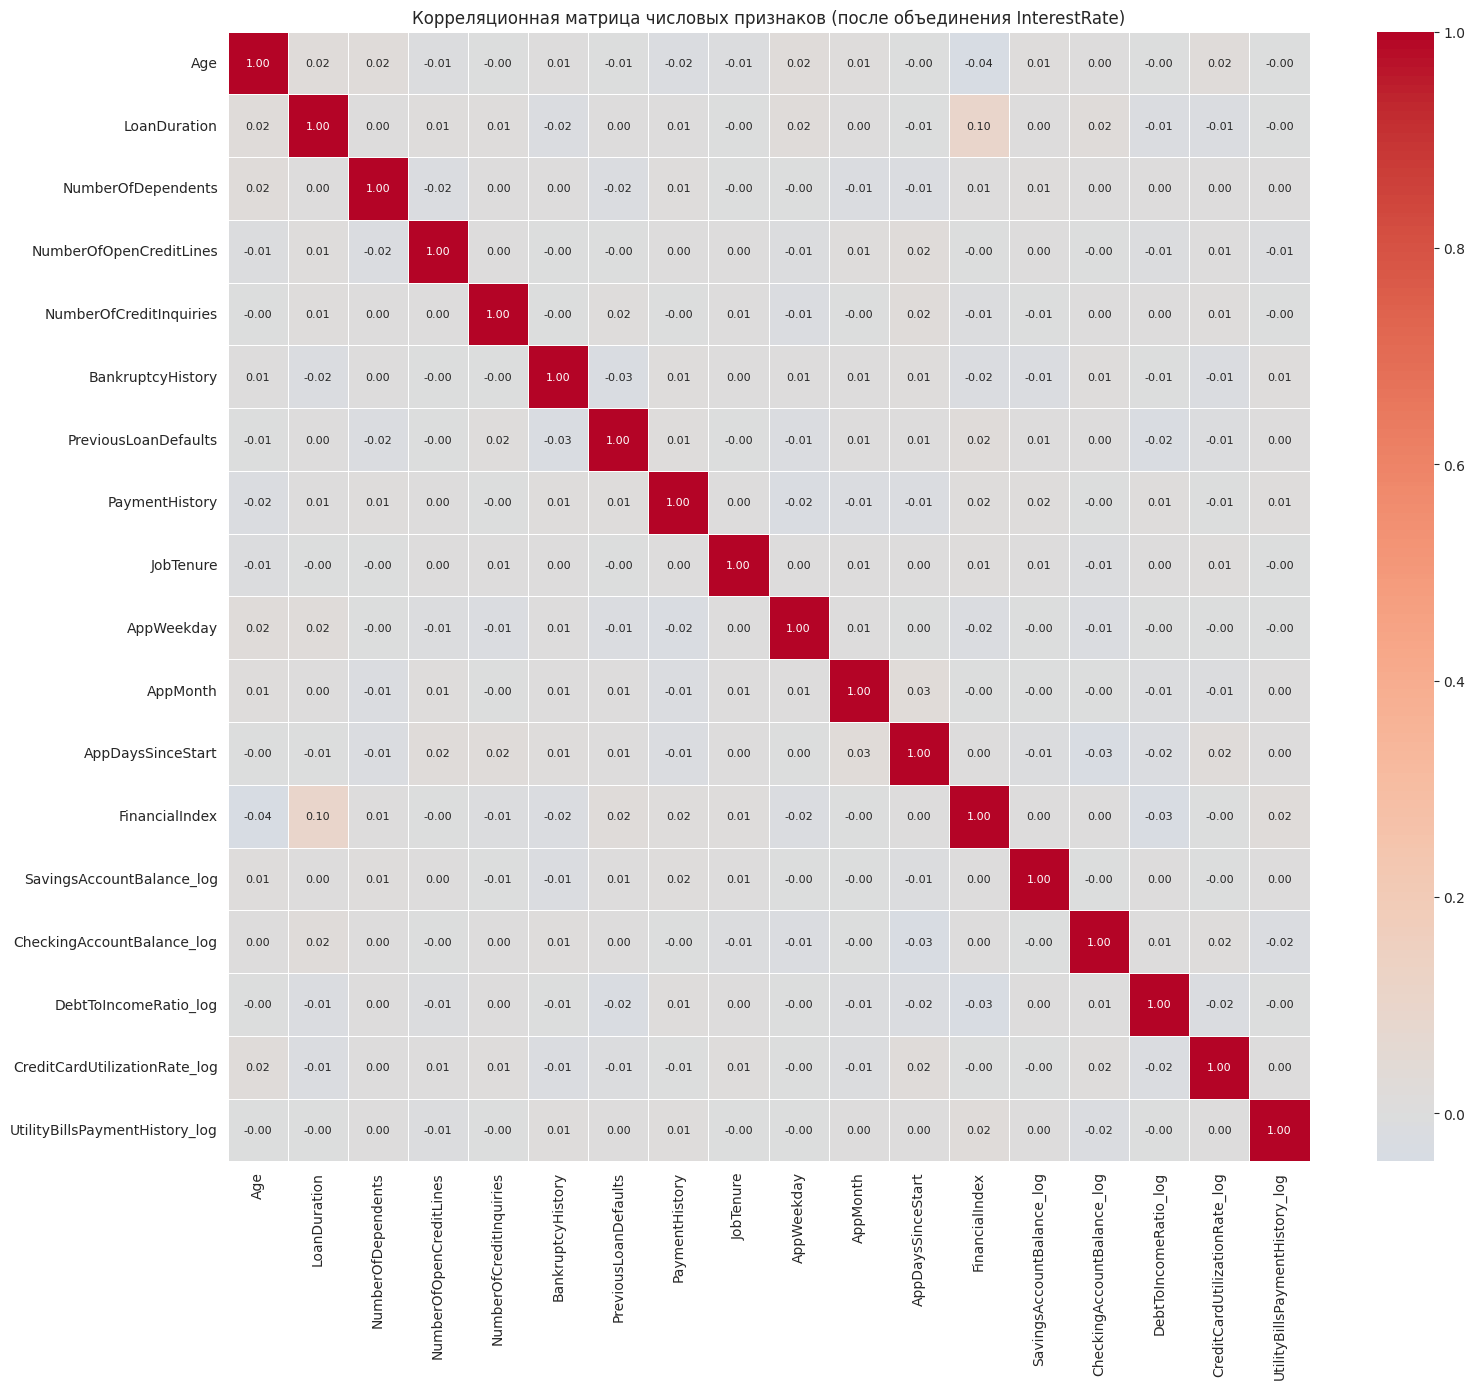

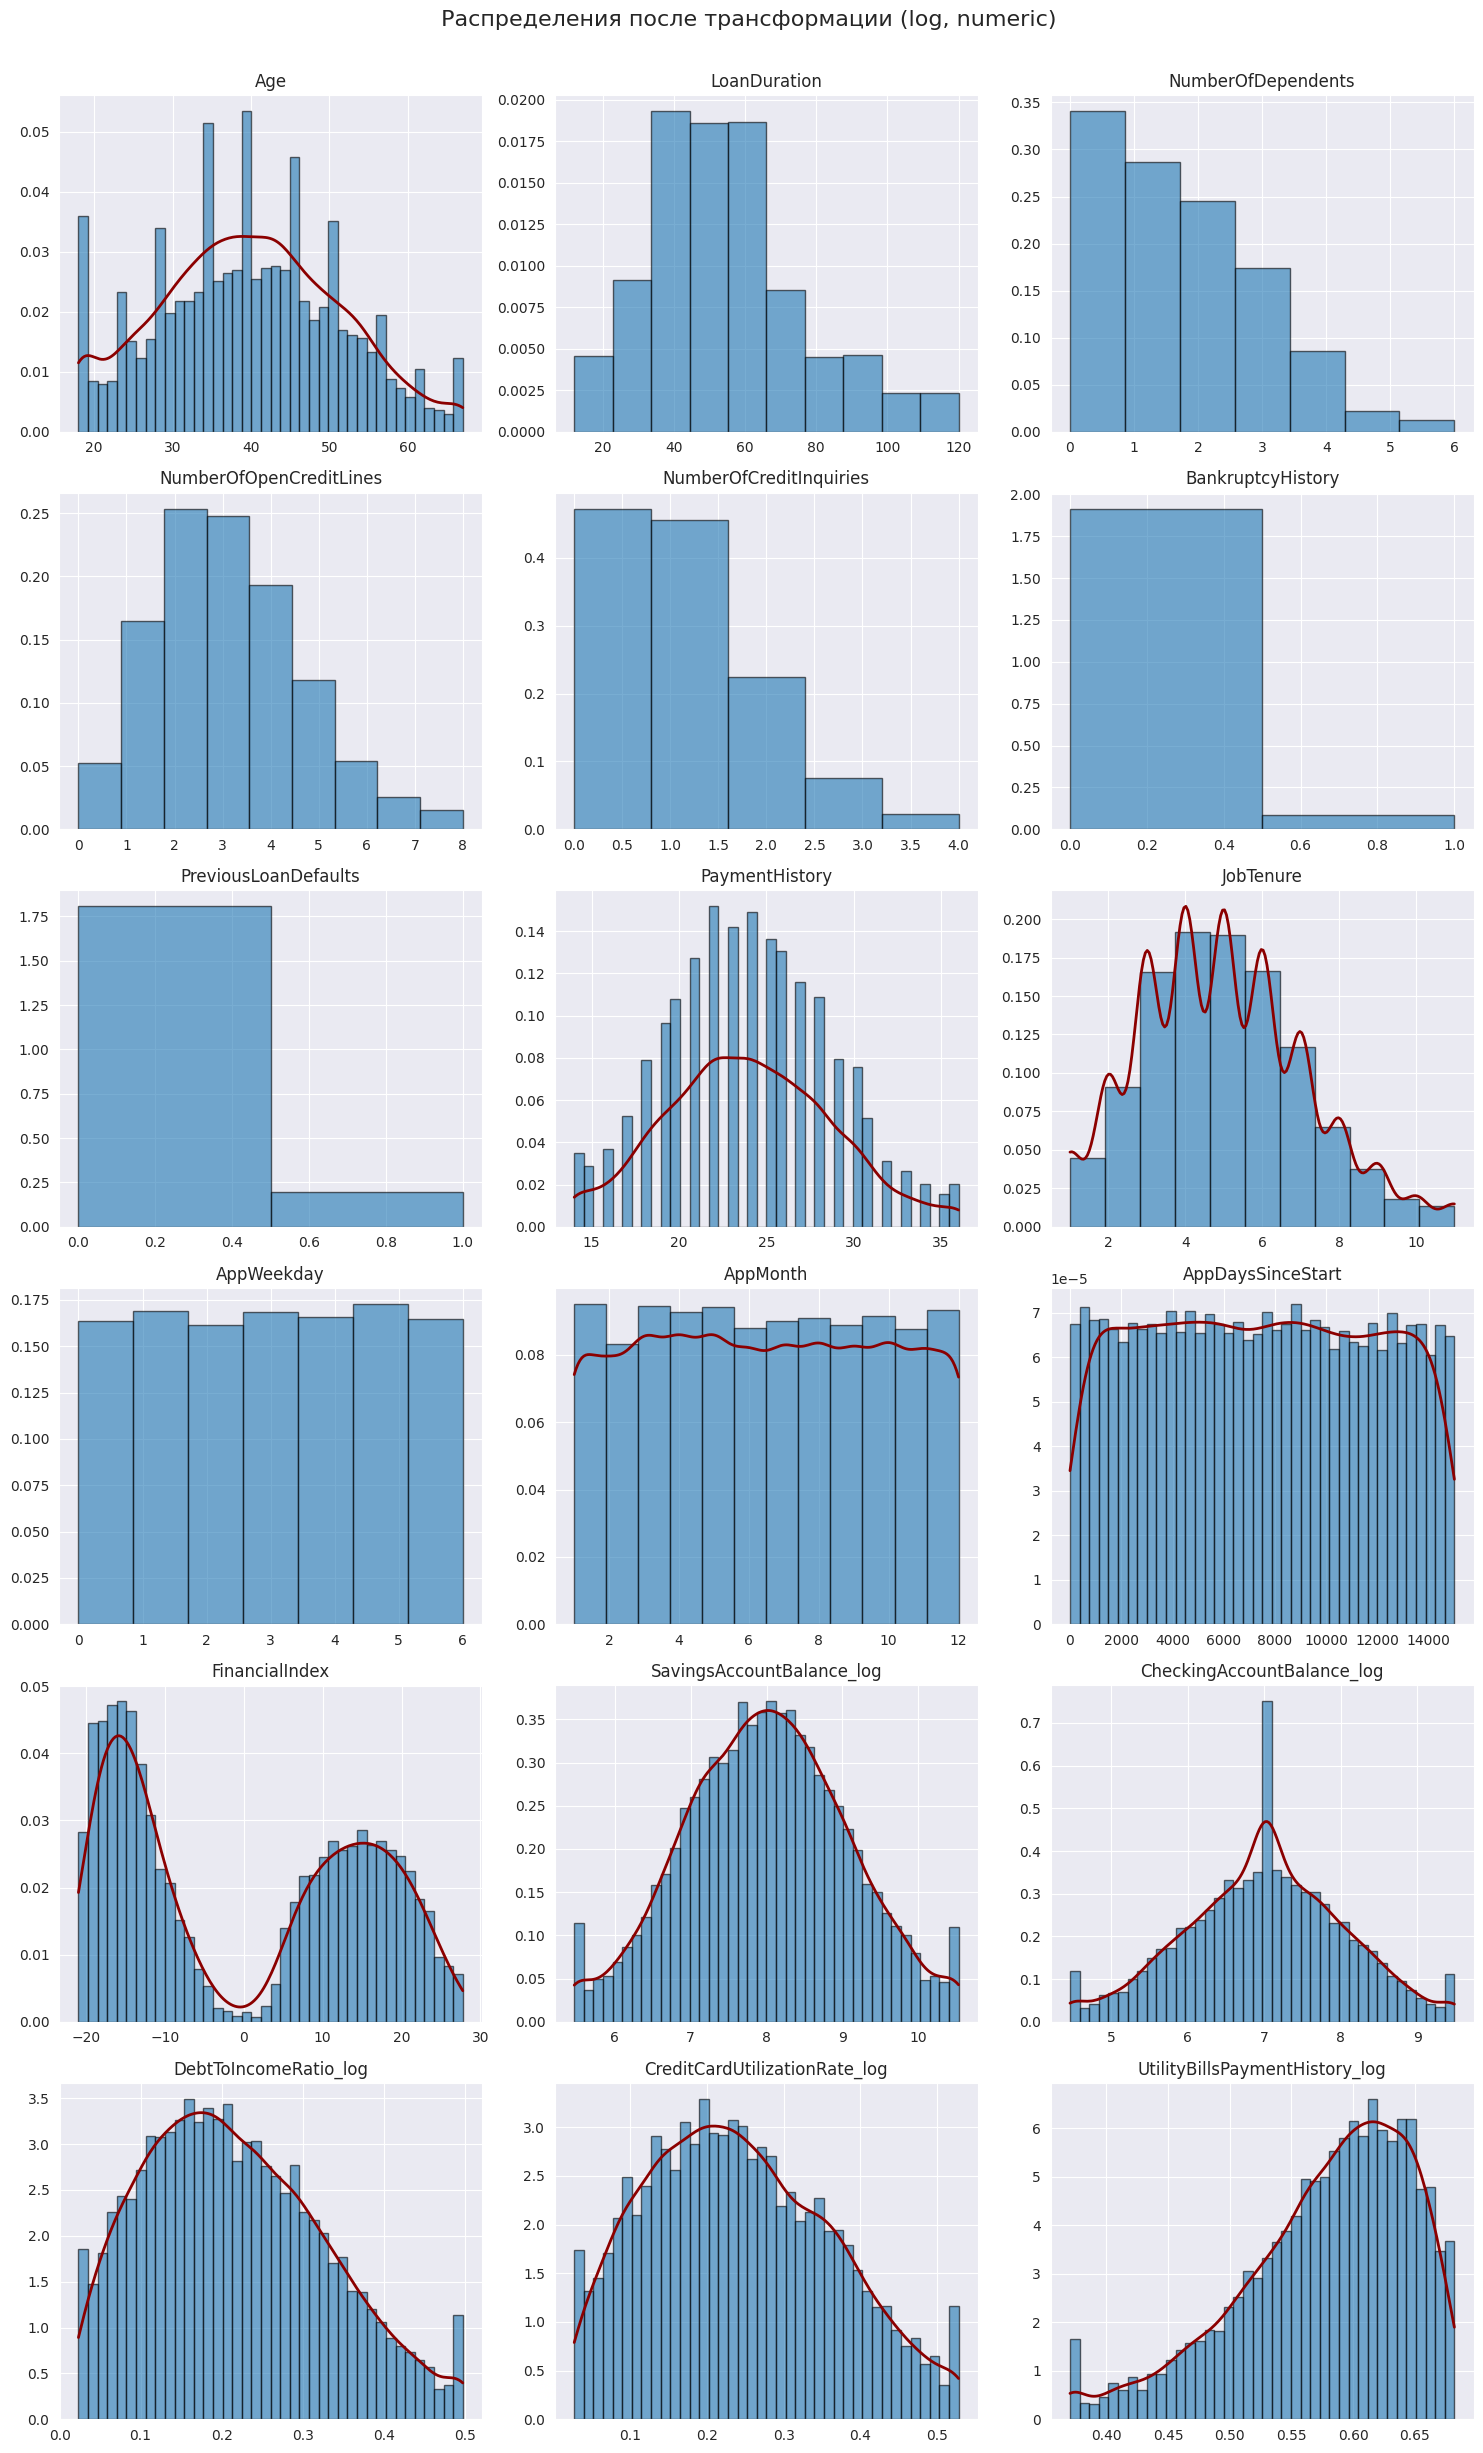

In [30]:
def get_correlated_pairs(df, threshold=0.15):
    corr_matrix = df.corr().abs()
    correlated_pairs = []

    # Проходим только по верхнему треугольнику матрицы, без диагонали
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr = corr_matrix.iloc[i, j]
            if corr > threshold:
                correlated_pairs.append((col1, col2, corr))

    # Сортировка по убыванию корреляции
    correlated_pairs = sorted(correlated_pairs, key=lambda x: abs(x[2]), reverse=True)

    return correlated_pairs

# Пример использования
correlated = get_correlated_pairs(df_filtered, threshold=0.15)
for col1, col2, corr in correlated:
    print(f"{col1:30} — {col2:30} → {corr:.2f}")

    num_cols = df_filtered.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")
df_num = df_filtered[num_cols].fillna(df_filtered[num_cols].median())


corr = df_num.corr()

# 4. Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Корреляционная матрица числовых признаков (после объединения InterestRate)")
plt.tight_layout()
plt.show()

# --- 4. Визуализация по обработанному df ---
# Только числовые признаки (логарифмированные и оставшиеся)
num_cols = [col for col in df_filtered.columns if col != "RiskScore" and np.issubdtype(df_filtered[col].dtype, np.number)]

n = len(num_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(nrows, ncols, i)
    data = df_filtered[col].dropna()

    bins = 40 if data.nunique() > 20 else data.nunique()
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.6, density=True)

    if data.nunique() > 10:
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 200)
        plt.plot(x_vals, kde(x_vals), color='darkred', linewidth=2)

    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.suptitle(" Распределения после трансформации (log, numeric)", fontsize=16, y=1.02)
plt.show()


### Удалим  AppDaysSinceStart

In [31]:
time_cols = ["AppWeekday", "AppMonth", "AppDaysSinceStart"]
correlations = df_filtered[time_cols + ["RiskScore"]].corr()["RiskScore"].drop("RiskScore")

print("📊 Корреляция временных признаков с RiskScore:")
print(correlations)


📊 Корреляция временных признаков с RiskScore:
AppWeekday          -0.016685
AppMonth            -0.006399
AppDaysSinceStart    0.005186
Name: RiskScore, dtype: float64


In [32]:
to_drop = ["AppWeekday", "AppDaysSinceStart"]

df_filtered.drop(columns=to_drop, inplace=True)
X_prepared.drop(columns=to_drop, inplace=True, errors="ignore")

print("🗑 Удалены слабые временные признаки:", to_drop)
print("✅ Оставлен AppMonth — возможная сезонность")

🗑 Удалены слабые временные признаки: ['AppWeekday', 'AppDaysSinceStart']
✅ Оставлен AppMonth — возможная сезонность


In [33]:
cols_to_drop = [
    "MaritalStatus_Married",
    "EducationLevel_High School",
    "HomeOwnershipStatus_Rent",
    "LoanPurpose_Debt Consolidation"
]

X_prepared.drop(columns=[col for col in cols_to_drop if col in X_prepared.columns], inplace=True)
df_filtered.drop(columns=[col for col in cols_to_drop if col in df_filtered.columns], inplace=True)

print("🗑 Удалены one-hot признаки для устранения мультиколлинеарности:", cols_to_drop)


🗑 Удалены one-hot признаки для устранения мультиколлинеарности: ['MaritalStatus_Married', 'EducationLevel_High School', 'HomeOwnershipStatus_Rent', 'LoanPurpose_Debt Consolidation']


In [34]:
print("Категориальные:", X_prepared.select_dtypes(include="object").columns.tolist())
print("Числовые:", X_prepared.select_dtypes(include="number").columns.tolist())
print(X_prepared.dtypes)
print(X_prepared.columns.tolist())

Категориальные: []
Числовые: ['SavingsAccountBalance_log', 'CheckingAccountBalance_log', 'DebtToIncomeRatio_log', 'CreditCardUtilizationRate_log', 'UtilityBillsPaymentHistory_log', 'Age', 'LoanDuration', 'NumberOfDependents', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'JobTenure', 'AppMonth', 'FinancialIndex', 'SavingsAccountBalance_log', 'CheckingAccountBalance_log', 'DebtToIncomeRatio_log', 'CreditCardUtilizationRate_log', 'UtilityBillsPaymentHistory_log']
SavingsAccountBalance_log         float64
CheckingAccountBalance_log        float64
DebtToIncomeRatio_log             float64
CreditCardUtilizationRate_log     float64
UtilityBillsPaymentHistory_log    float64
CreditScore_(600.0, 700.0]           bool
CreditScore_(700.0, 750.0]           bool
CreditScore_(750.0, 800.0]           bool
CreditScore_(800.0, 850.0]           bool
Age                               float64
LoanDuration                      float64
N

In [35]:
set_X = set(X_prepared.columns)
set_df = set(df_filtered.columns)

only_in_X = sorted(set_X - set_df)
only_in_df = sorted(set_df - set_X)

print("🔹 Только в X_prepared:", only_in_X)
print("🔸 Только в df_filtered:", only_in_df)


🔹 Только в X_prepared: ['CreditScore_(600.0, 700.0]', 'CreditScore_(700.0, 750.0]', 'CreditScore_(750.0, 800.0]', 'CreditScore_(800.0, 850.0]']
🔸 Только в df_filtered: ['EducationLevel_Bachelor', 'EducationLevel_Doctorate', 'EducationLevel_Master', 'EmploymentStatus_Self-Employed', 'EmploymentStatus_Unemployed', 'HomeOwnershipStatus_Other', 'HomeOwnershipStatus_Own', 'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Other', 'LoanPurpose_Unknown', 'MaritalStatus_Single', 'MaritalStatus_Widowed', 'RiskScore']


In [36]:
categorical_cols = df_filtered.select_dtypes(include="bool").columns.tolist()
X_prepared = pd.concat([X_prepared, df_filtered[categorical_cols]], axis=1)


In [37]:
# Признаки и типы
types_X = X_prepared.dtypes.to_dict()
types_df = df_filtered.dtypes.to_dict()

# Названия колонок
set_X = set(types_X)
set_df = set(types_df)

# Только в X_prepared
only_in_X = sorted(set_X - set_df)
print("🔹 Только в X_prepared:")
for col in only_in_X:
    print(f"  {col:40} — {types_X[col]}")

# Только в df_filtered
only_in_df = sorted(set_df - set_X)
print("\n🔸 Только в df_filtered:")
for col in only_in_df:
    print(f"  {col:40} — {types_df[col]}")


🔹 Только в X_prepared:
  CreditScore_(600.0, 700.0]               — bool
  CreditScore_(700.0, 750.0]               — bool
  CreditScore_(750.0, 800.0]               — bool
  CreditScore_(800.0, 850.0]               — bool

🔸 Только в df_filtered:
  RiskScore                                — float64


In [38]:
print("Категориальные:", X_prepared.select_dtypes(include="object").columns.tolist())
print("Числовые:", X_prepared.select_dtypes(include="number").columns.tolist())
print(X_prepared.dtypes)
print(X_prepared.columns.tolist())

Категориальные: []
Числовые: ['SavingsAccountBalance_log', 'CheckingAccountBalance_log', 'DebtToIncomeRatio_log', 'CreditCardUtilizationRate_log', 'UtilityBillsPaymentHistory_log', 'Age', 'LoanDuration', 'NumberOfDependents', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'JobTenure', 'AppMonth', 'FinancialIndex', 'SavingsAccountBalance_log', 'CheckingAccountBalance_log', 'DebtToIncomeRatio_log', 'CreditCardUtilizationRate_log', 'UtilityBillsPaymentHistory_log']
SavingsAccountBalance_log         float64
CheckingAccountBalance_log        float64
DebtToIncomeRatio_log             float64
CreditCardUtilizationRate_log     float64
UtilityBillsPaymentHistory_log    float64
CreditScore_(600.0, 700.0]           bool
CreditScore_(700.0, 750.0]           bool
CreditScore_(750.0, 800.0]           bool
CreditScore_(800.0, 850.0]           bool
Age                               float64
LoanDuration                      float64
N

In [39]:
def generate_feature_markdown(X_prepared):
    log_features = [col for col in X_prepared.columns if col.endswith("_log")]
    bin_features = [col for col in X_prepared.columns if "CreditScore_(" in col]
    engineered_features = ["FinancialIndex"]
    month_feature = ["AppMonth"]
    one_hot_prefixes = [
        "EducationLevel_", "EmploymentStatus_", "HomeOwnershipStatus_",
        "LoanPurpose_", "MaritalStatus_"
    ]
    cat_features = [col for col in X_prepared.columns if any(col.startswith(p) for p in one_hot_prefixes)]
    base_numeric = [
        "Age", "LoanDuration", "NumberOfDependents", "NumberOfOpenCreditLines",
        "NumberOfCreditInquiries", "BankruptcyHistory", "PreviousLoanDefaults",
        "PaymentHistory", "JobTenure"
    ]

    markdown = "| Признак | Категория | Описание |\n"
    markdown += "|---------|-----------|----------|\n"

    for col in X_prepared.columns:
        if col in log_features:
            cat = "Логарифмированный числовой"
            desc = "Сглаживает выбросы, делает признак более «нормальным»"
        elif col in bin_features:
            cat = "Биннинг CreditScore"
            desc = "Интервал кредитного скоринга (one-hot)"
        elif col in engineered_features:
            cat = "Инженерный"
            desc = "Агрегатный индекс платёжеспособности (на основе линейной модели)"
        elif col in month_feature:
            cat = "Временной"
            desc = "Месяц подачи заявки, возможная сезонность"
        elif col in cat_features:
            cat = "Категориальный (one-hot)"
            desc = "Закодированные категориальные признаки (напр. образование, цель займа)"
        elif col in base_numeric:
            cat = "Базовый числовой"
            desc = "Классический числовой признак (возраст, стаж и т.п.)"
        else:
            cat = "❓ Не классифицирован"
            desc = "Нужно проверить вручную"

        markdown += f"| `{col}` | {cat} | {desc} |\n"

    return markdown

# Сгенерировать и вывести
md = generate_feature_markdown(X_prepared)
print(md)


| Признак | Категория | Описание |
|---------|-----------|----------|
| `SavingsAccountBalance_log` | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `CheckingAccountBalance_log` | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `DebtToIncomeRatio_log` | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `CreditCardUtilizationRate_log` | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `UtilityBillsPaymentHistory_log` | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `CreditScore_(600.0, 700.0]` | Биннинг CreditScore | Интервал кредитного скоринга (one-hot) |
| `CreditScore_(700.0, 750.0]` | Биннинг CreditScore | Интервал кредитного скоринга (one-hot) |
| `CreditScore_(750.0, 800.0]` | Биннинг CreditScore | Интервал кредитного скоринга (one-hot) |
| `CreditScore_(800.0, 850.0]` | Биннинг CreditScor

# Итог

| Признак                          | Категория                  | Описание |
|----------------------------------|----------------------------|----------|
| `SavingsAccountBalance_log`      | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `CheckingAccountBalance_log`     | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `DebtToIncomeRatio_log`          | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `CreditCardUtilizationRate_log`  | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `UtilityBillsPaymentHistory_log` | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `CreditScore_(600.0, 700.0]`     | Биннинг CreditScore        | Интервал кредитного скоринга (one-hot) |
| `CreditScore_(700.0, 750.0]`     | Биннинг CreditScore        | Интервал кредитного скоринга (one-hot) |
| `CreditScore_(750.0, 800.0]`     | Биннинг CreditScore        | Интервал кредитного скоринга (one-hot) |
| `CreditScore_(800.0, 850.0]`     | Биннинг CreditScore        | Интервал кредитного скоринга (one-hot) |
| `Age`                            | Базовый числовой           | Классический числовой признак (возраст, стаж и т.п.) |
| `LoanDuration`                   | Базовый числовой           | Классический числовой признак (возраст, стаж и т.п.) |
| `NumberOfDependents`             | Базовый числовой           | Классический числовой признак (возраст, стаж и т.п.) |
| `NumberOfOpenCreditLines`        | Базовый числовой           | Классический числовой признак (возраст, стаж и т.п.) |
| `NumberOfCreditInquiries`        | Базовый числовой           | Классический числовой признак (возраст, стаж и т.п.) |
| `BankruptcyHistory`              | Базовый числовой           | Классический числовой признак (возраст, стаж и т.п.) |
| `PreviousLoanDefaults`           | Базовый числовой           | Классический числовой признак (возраст, стаж и т.п.) |
| `PaymentHistory`                 | Базовый числовой           | Классический числовой признак (возраст, стаж и т.п.) |
| `JobTenure`                      | Базовый числовой           | Классический числовой признак (возраст, стаж и т.п.) |
| `AppMonth`                       | Временной                  | Месяц подачи заявки, возможная сезонность |
| `FinancialIndex`                 | Инженерный                 | Агрегатный индекс платёжеспособности (на основе линейной модели) |
| `SavingsAccountBalance_log`      | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `CheckingAccountBalance_log`     | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `DebtToIncomeRatio_log`          | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `CreditCardUtilizationRate_log`  | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `UtilityBillsPaymentHistory_log` | Логарифмированный числовой | Сглаживает выбросы, делает признак более «нормальным» |
| `EmploymentStatus_Self-Employed` | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `EmploymentStatus_Unemployed`    | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `MaritalStatus_Married`          | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `MaritalStatus_Single`           | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `MaritalStatus_Widowed`          | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `HomeOwnershipStatus_Other`      | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `HomeOwnershipStatus_Own`        | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `HomeOwnershipStatus_Rent`       | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `LoanPurpose_Debt Consolidation` | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `LoanPurpose_Education`          | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `LoanPurpose_Home`               | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `LoanPurpose_Other`              | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `LoanPurpose_Unknown`            | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `EducationLevel_Bachelor`        | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `EducationLevel_Doctorate`       | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `EducationLevel_High School`     | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |
| `EducationLevel_Master`          | Категориальный (one-hot)   | Закодированные категориальные признаки (напр. образование, цель займа) |


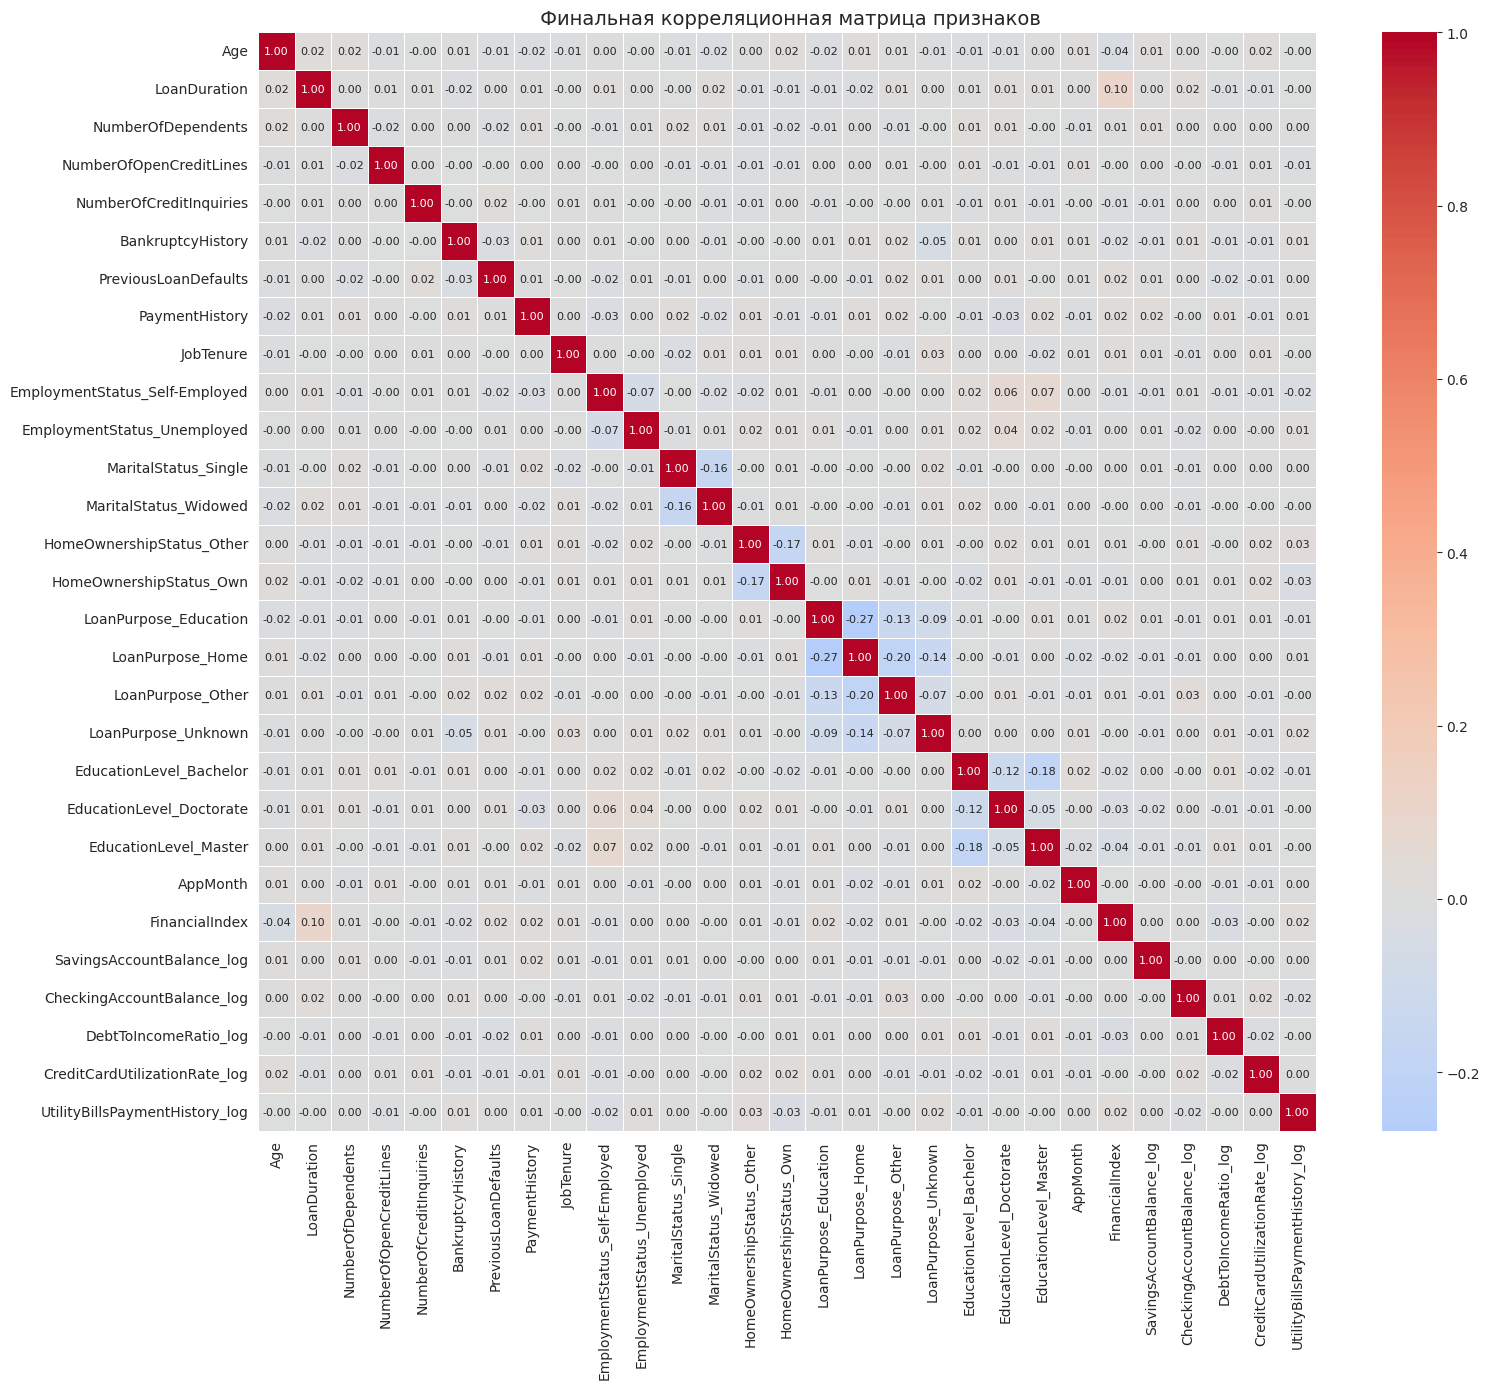

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Только числовые + булевы признаки, без таргета
num_cols = df_filtered.select_dtypes(include=["number", "bool"]).columns.drop("RiskScore", errors="ignore")

# Защита от пропусков
df_corr_input = df_filtered[num_cols].copy()
df_corr_input = df_corr_input.fillna(df_corr_input.median(numeric_only=True))

# Корреляционная матрица
corr = df_corr_input.corr()

# Визуализация
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title(" Финальная корреляционная матрица признаков", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


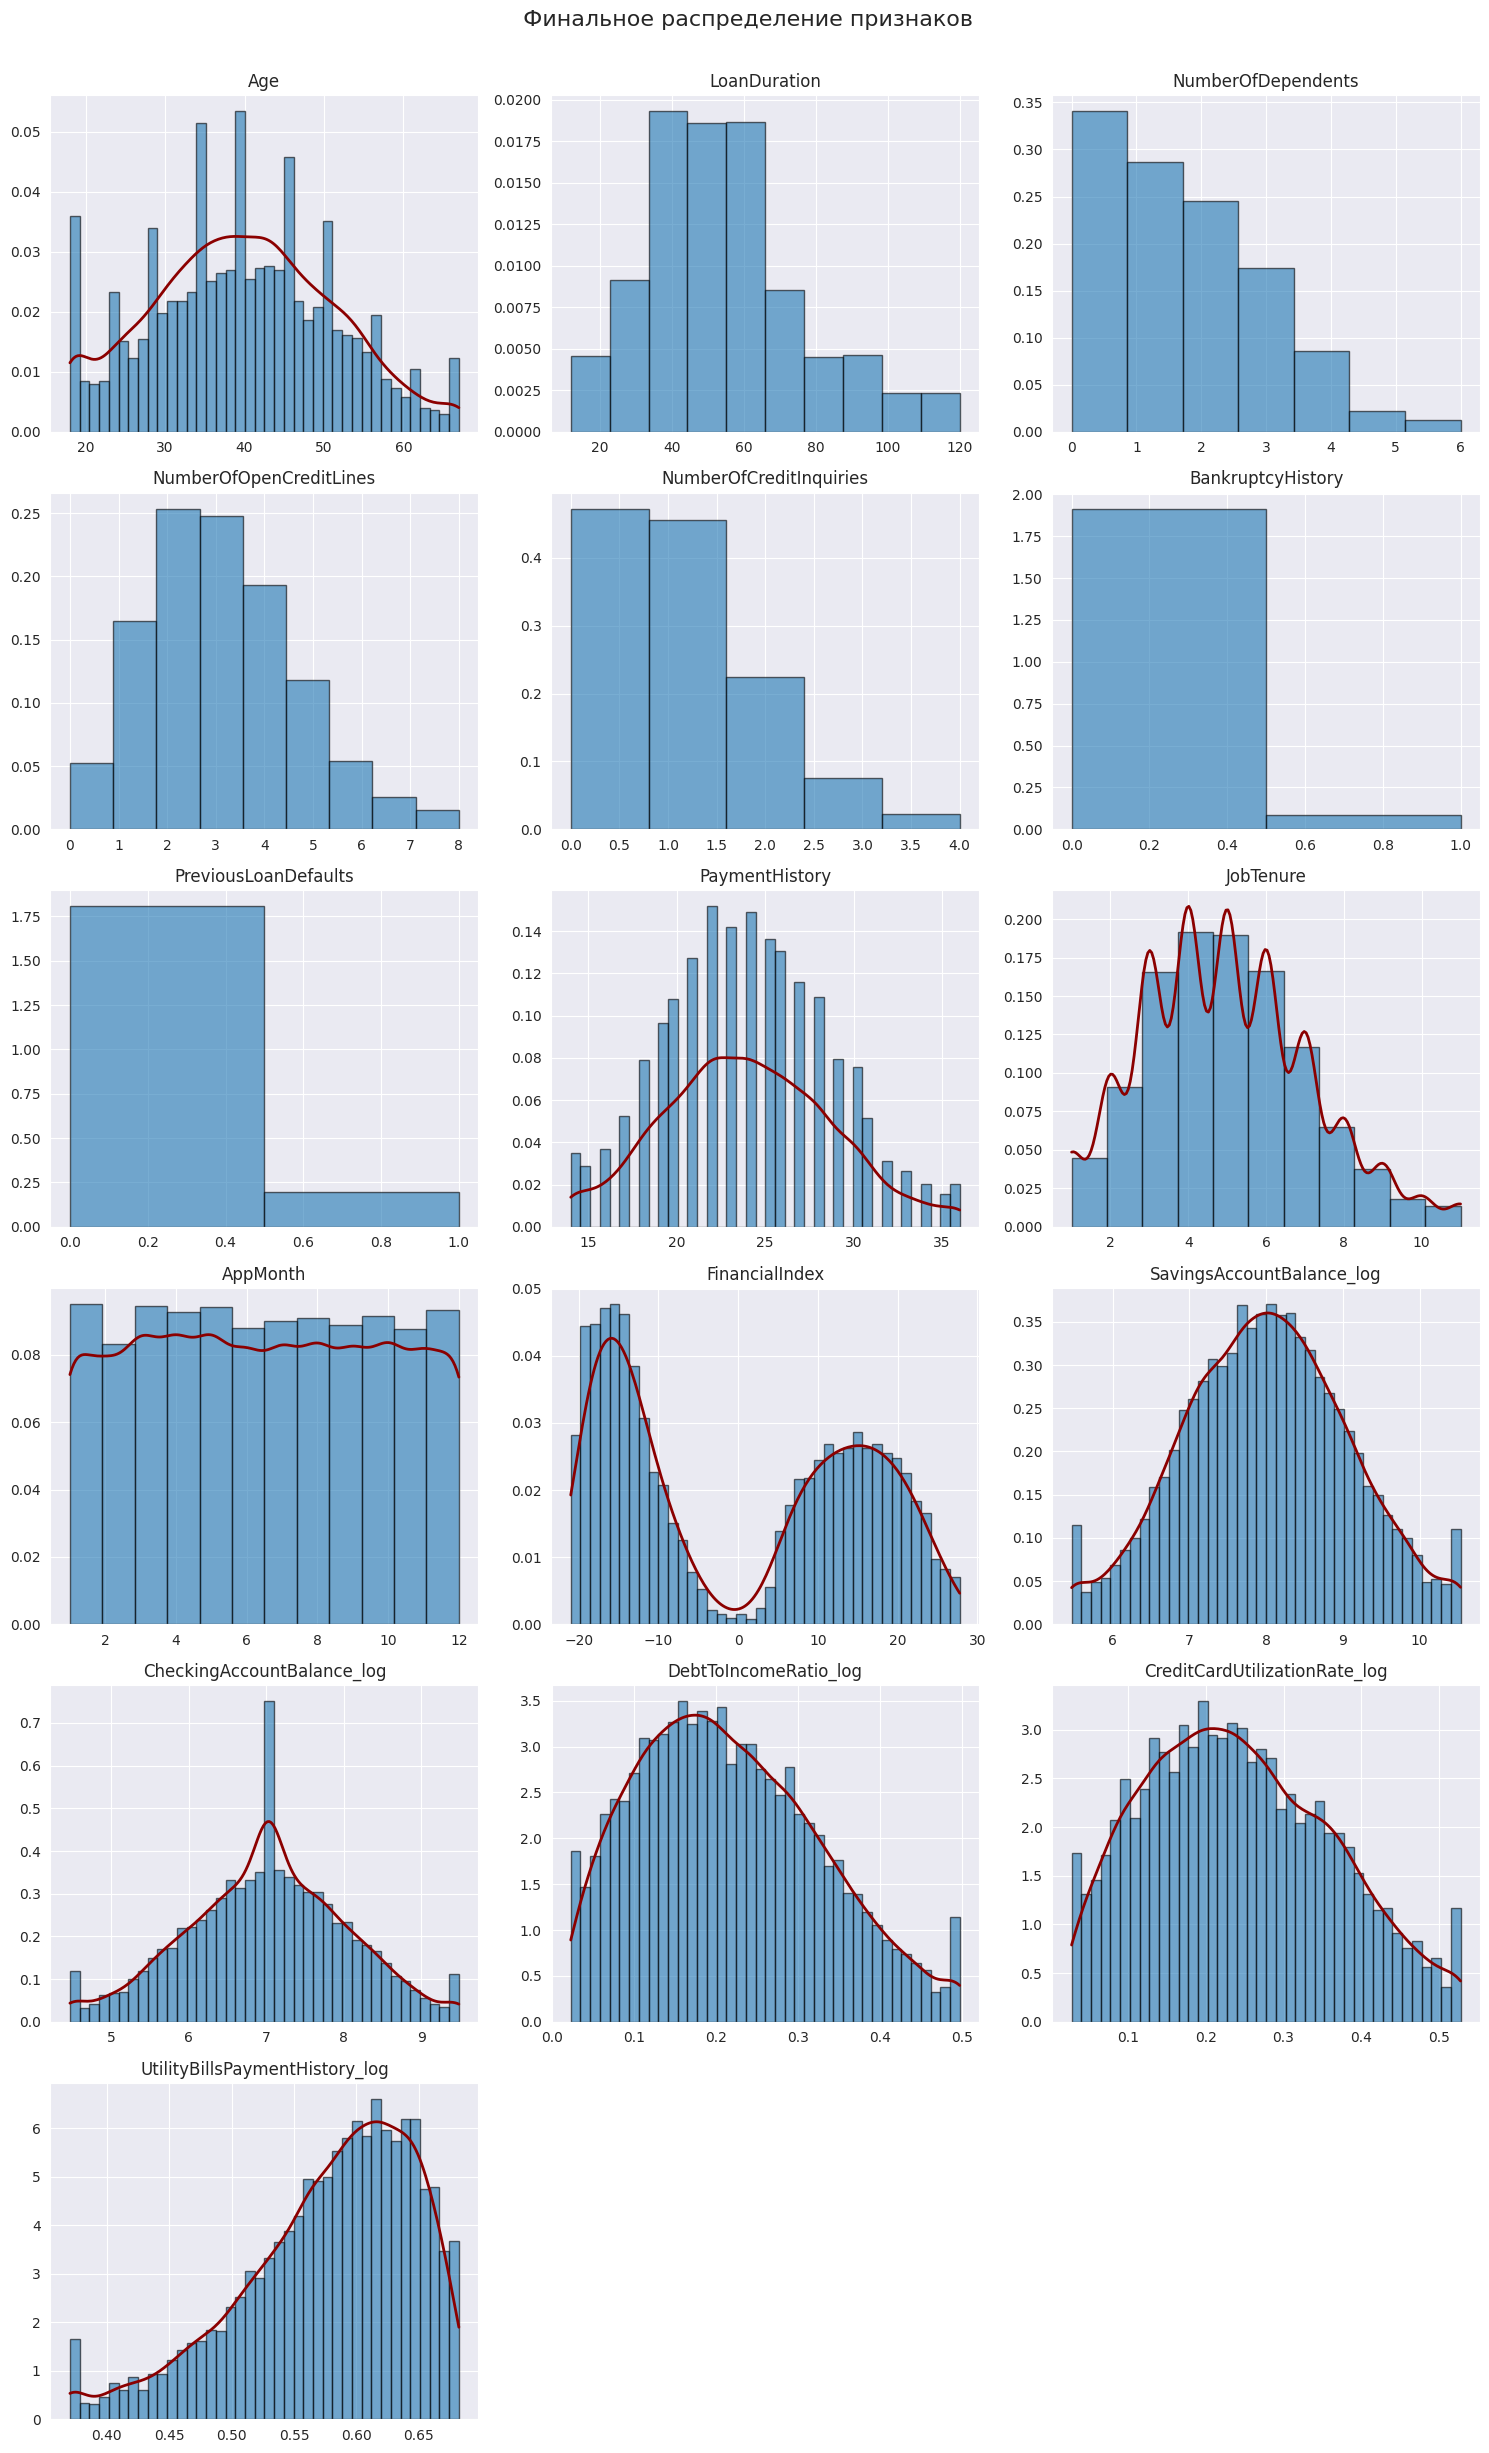

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np

# Выберем только числовые + булевы (one-hot), кроме RiskScore
plot_cols = [
    col for col in df_filtered.columns
    if col != "RiskScore" and np.issubdtype(df_filtered[col].dtype, np.number) and df_filtered[col].dtype != bool
]


n = len(plot_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(plot_cols, 1):
    plt.subplot(nrows, ncols, i)
    data = df_filtered[col].dropna()

    bins = 40 if data.nunique() > 20 else data.nunique()
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.6, density=True)

    if data.nunique() > 10:
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 200)
        plt.plot(x_vals, kde(x_vals), color='darkred', linewidth=2)

    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.suptitle(" Финальное распределение признаков", fontsize=16, y=1.02)
plt.show()


### УРРАРАРАРАРА. Данные подготовлены

# Normalize data

In [42]:
from normalization import normalize_zscore

X = X_prepared.copy()
X_norm, (mean_X, std_X) = normalize_zscore(X)

y = df_filtered["RiskScore"].values

print(" Данные нормализованы (Z-score), X.shape =", X_norm.shape)


# Regulirization

In [43]:
print("min y:", np.min(y))
print("max y:", np.max(y))


min y: 23.15999431809419
max y: 82.33644026251814


<class 'numpy.ndarray'>
(10067,)
0


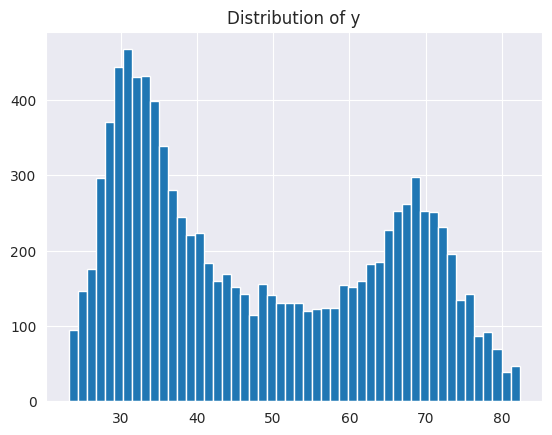

In [44]:
print(type(y))          # должен быть numpy.ndarray или pd.Series
print(y.shape)          # (n_samples,)
print(np.isnan(y).sum())  # должны быть нули
import matplotlib.pyplot as plt
plt.hist(y, bins=50)
plt.title("Distribution of y")
plt.show()


In [45]:
from regularization import ridge_regression, lasso_regression, elastic_net_regression
from metrics import mean_squared_error_manual, mean_absolute_error_manual, r2_score_manual
from hyperparameter_tuning import grid_search_cv
from cross_validation import kfold_split
import numpy as np

cv = kfold_split(X_norm, n_splits=5, shuffle=True, random_state=42)


# === Обёртки моделей ===

class RidgeWrapper:
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X, y):
        X_b = np.c_[np.ones(len(X)), X]
        self.w_hist, _ = ridge_regression(X_b, y, alpha=self.alpha, alpha_lr=0.001, n_iters=1000)
        self.w = self.w_hist[-1]

    def predict(self, X):
        X_b = np.c_[np.ones(len(X)), X]
        return X_b @ self.w



class LassoWrapper:
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X, y):
        X_b = np.c_[np.ones(len(X)), X]
        self.w_hist, _ = lasso_regression(X_b, y, alpha=self.alpha, alpha_lr=0.001, n_iters=1000)
        self.w = self.w_hist[-1]

    def predict(self, X):
        X_b = np.c_[np.ones(len(X)), X]
        return X_b @ self.w



class ElasticNetWrapper:
    def __init__(self, alpha1, alpha2):
        self.alpha1 = alpha1
        self.alpha2 = alpha2

    def fit(self, X, y):
        X_b = np.c_[np.ones(len(X)), X]
        self.w_hist, _ = elastic_net_regression(
            X_b, y,
            alpha1=self.alpha1,
            alpha2=self.alpha2,
            alpha_lr=0.001,
            n_iters=1000
        )
        self.w = self.w_hist[-1]

    def predict(self, X):
        X_b = np.c_[np.ones(len(X)), X]
        return X_b @ self.w



# === Параметры сетки ===
grid_ridge = {"alpha": [1e-5, 1e-4, 1e-3, 1e-2]}
grid_lasso = {"alpha": [1e-5, 1e-4, 1e-3, 1e-2, 0.1]}
grid_elastic = {
    "alpha1": [1e-4, 1e-3, 1e-2],
    "alpha2": [1e-4, 1e-3, 1e-2]
}

# === Grid Search ===

print("\n🔍 Ridge:")
best_ridge, score_ridge, _ = grid_search_cv(RidgeWrapper, grid_ridge, X_norm, y, cv=cv,
                                            scoring=mean_squared_error_manual, verbose=True)

print("\n🔍 Lasso:")
best_lasso, score_lasso, _ = grid_search_cv(LassoWrapper, grid_lasso, X_norm, y, cv=cv,
                                            scoring=mean_squared_error_manual, verbose=True)

print("\n🔍 ElasticNet:")
best_elastic, score_elastic, _ = grid_search_cv(ElasticNetWrapper, grid_elastic, X_norm, y, cv=cv,
                                                scoring=mean_squared_error_manual, verbose=True)


# === Финальное обучение и метрики ===
def report(name, model_class, params):
    model = model_class(**params)
    model.fit(X_norm, y)
    y_pred = model.predict(X_norm)
    print(f"\n📊 {name}:")
    print("Best params:", params)
    print("MSE  =", mean_squared_error_manual(y, y_pred))
    print("MAE  =", mean_absolute_error_manual(y, y_pred))
    print("R²   =", r2_score_manual(y, y_pred))
    print("mean |w|:", np.mean(np.abs(model.w)))
    print("non-zero weights:", np.count_nonzero(np.abs(model.w) > 1e-4))


report("Ridge", RidgeWrapper, best_ridge)
report("Lasso", LassoWrapper, best_lasso)
report("ElasticNet", ElasticNetWrapper, best_elastic)





🔍 Ridge:


/home/sergey/PycharmProjects/ML_UNI/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/regularization.py:61: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(loss_history[-1] - loss_history[-2]) < tol:
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/regularization.py:57: RuntimeWarning: overflow encountered in square
  loss = np.mean((X_arr.dot(w) - y_arr) ** 2) + alpha * np.sum(w ** 2)
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/regularization.py:56: RuntimeWarning: invalid value encountered in subtract
  w = w - alpha_lr * grad
/home/sergey/PycharmProjects/ML_UNI/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[1/4] params={'alpha': 1e-05}  mean_score=nan
[2/4] params={'alpha': 0.0001}  mean_score=nan
[3/4] params={'alpha': 0.001}  mean_score=nan
[4/4] params={'alpha': 0.01}  mean_score=nan

🔍 Lasso:


/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/regularization.py:30: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(loss_history[-1] - loss_history[-2]) < tol:
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/regularization.py:27: RuntimeWarning: overflow encountered in square
  loss = np.mean((X_arr.dot(w) - y_arr) ** 2) + alpha * np.sum(np.abs(w))
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/regularization.py:23: RuntimeWarning: invalid value encountered in subtract
  w_temp = w - alpha_lr * grad


[1/5] params={'alpha': 1e-05}  mean_score=nan
[2/5] params={'alpha': 0.0001}  mean_score=nan
[3/5] params={'alpha': 0.001}  mean_score=nan
[4/5] params={'alpha': 0.01}  mean_score=nan
[5/5] params={'alpha': 0.1}  mean_score=nan

🔍 ElasticNet:


/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/regularization.py:96: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(loss_history[-1] - loss_history[-2]) < tol:
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/regularization.py:90: RuntimeWarning: overflow encountered in square
  loss = (np.mean((X_arr.dot(w) - y_arr) ** 2)
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/regularization.py:92: RuntimeWarning: overflow encountered in square
  + alpha2 * np.sum(w ** 2))
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/regularization.py:89: RuntimeWarning: invalid value encountered in subtract
  w = w - alpha_lr * grad


[1/9] params={'alpha1': 0.0001, 'alpha2': 0.0001}  mean_score=nan
[2/9] params={'alpha1': 0.0001, 'alpha2': 0.001}  mean_score=nan
[3/9] params={'alpha1': 0.0001, 'alpha2': 0.01}  mean_score=nan
[4/9] params={'alpha1': 0.001, 'alpha2': 0.0001}  mean_score=nan
[5/9] params={'alpha1': 0.001, 'alpha2': 0.001}  mean_score=nan
[6/9] params={'alpha1': 0.001, 'alpha2': 0.01}  mean_score=nan
[7/9] params={'alpha1': 0.01, 'alpha2': 0.0001}  mean_score=nan
[8/9] params={'alpha1': 0.01, 'alpha2': 0.001}  mean_score=nan
[9/9] params={'alpha1': 0.01, 'alpha2': 0.01}  mean_score=nan

📊 Ridge:
Best params: {'alpha': 1e-05}
MSE  = nan
MAE  = nan
R²   = nan
mean |w|: nan
non-zero weights: 0

📊 Lasso:
Best params: {'alpha': 1e-05}
MSE  = nan
MAE  = nan
R²   = nan
mean |w|: nan
non-zero weights: 0

📊 ElasticNet:
Best params: {'alpha1': 0.0001, 'alpha2': 0.0001}
MSE  = nan
MAE  = nan
R²   = nan
mean |w|: nan
non-zero weights: 0


In [46]:
y_mean = np.mean(y)
mse_const = mean_squared_error_manual(y, np.full_like(y, y_mean))
print("MSE const:", mse_const)


MSE const: 281.0892358607441


### k-fold и LOO

In [47]:
from cross_validation import kfold_split, cross_val_score_manual
from metrics import mean_squared_error_manual, mean_absolute_error_manual, r2_score_manual
from linear_regression import LinearRegressionManual
import numpy as np

cv_kfold = kfold_split(X_norm, n_splits=5, shuffle=True, random_state=42)
methods = ["analytic", "gradient", "sgd"]

for method in methods:
    model = LinearRegressionManual(method=method)
    scores_kfold = cross_val_score_manual(model, X_norm, y, cv_kfold, mean_squared_error_manual)
    print(f"📊 {method.upper()} — KFold MSE mean: {np.mean(scores_kfold):.4f}")




📊 ANALYTIC — KFold MSE mean: 22.8035


/home/sergey/PycharmProjects/ML_UNI/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/gradient_descent.py:19: RuntimeWarning: overflow encountered in square
  current_loss = np.mean((X_arr.dot(w) - y_arr) ** 2)
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/gradient_descent.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(loss_history[-2] - loss_history[-1]) < tol:
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/gradient_descent.py:18: RuntimeWarning: invalid value encountered in subtract
  w = w - alpha * grad


📊 GRADIENT — KFold MSE mean: nan


/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/gradient_descent.py:49: RuntimeWarning: overflow encountered in multiply
  grad = 2.0 * xi.T.dot(xi.dot(w) - yi)
/home/sergey/PycharmProjects/ML_UNI/LAB_1/mai-ml-contest-1-2025-1/gradient_descent.py:50: RuntimeWarning: invalid value encountered in subtract
  w = w - alpha * grad.flatten()


KeyboardInterrupt: 

### Сравнение с sklearn

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sk_model = LinearRegression()
sk_model.fit(X_norm, y)
y_pred_sk = sk_model.predict(X_norm)

print(" Сравнение со sklearn:")
print("MSE manual     :", mean_squared_error_manual(y, y_pred_sk))
print("MSE sklearn    :", mean_squared_error(y, y_pred_sk))

print("MAE manual     :", mean_absolute_error_manual(y, y_pred_sk))
print("MAE sklearn    :", mean_absolute_error(y, y_pred_sk))

print("R² manual      :", r2_score_manual(y, y_pred_sk))
print("R² sklearn     :", r2_score(y, y_pred_sk))


 Сравнение со sklearn:
MSE manual     : 22.57732017772821
MSE sklearn    : 22.57732017772821
MAE manual     : 3.7343605983786152
MAE sklearn    : 3.7343605983786152
R² manual      : 0.9196791719590666
R² sklearn     : 0.9196791719590666


MSE (1 feature): 39.48031903753065


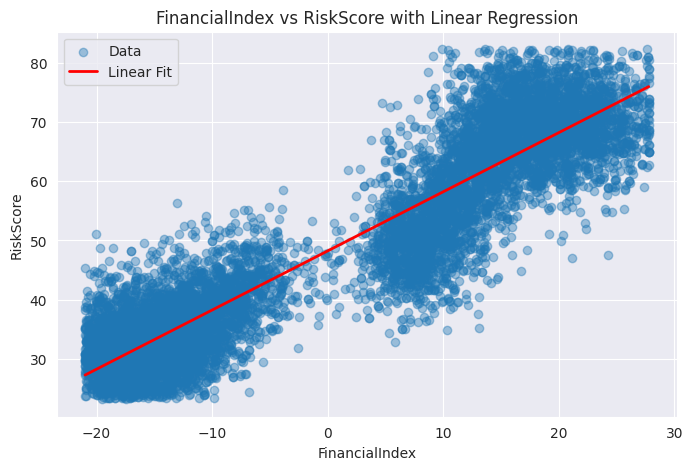

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Данные
X_single = df_filtered[["FinancialIndex"]].values
y = df_filtered["RiskScore"].values

# Обучение модели
model = LinearRegression()
model.fit(X_single, y)
y_pred = model.predict(X_single)

print("MSE (1 feature):", mean_squared_error_manual(y, y_pred))

# Построение scatter + прямой
plt.figure(figsize=(8, 5))
plt.scatter(X_single, y, alpha=0.4, label="Data")

# Прямая по отсортированным x
x_sorted = np.sort(X_single, axis=0)
y_line = model.predict(x_sorted)
plt.plot(x_sorted, y_line, color="red", linewidth=2, label="Linear Fit")

plt.title("FinancialIndex vs RiskScore with Linear Regression")
plt.xlabel("FinancialIndex")
plt.ylabel("RiskScore")
plt.legend()
plt.grid(True)
plt.show()


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

X_single = df_filtered[["FinancialIndex"]].values
X_poly = np.hstack([X_single, X_single**2])  # добавляем x²
y = df_filtered["RiskScore"].values

model_poly = LinearRegression()
model_poly.fit(X_poly, y)
y_pred_poly = model_poly.predict(X_poly)

print("MSE (poly x + x²):", mean_squared_error(y, y_pred_poly))


MSE (poly x + x²): 38.88292256289806


In [54]:
X_thresh = np.hstack([
    X_single,
    (X_single > 0).astype(int)  # бинарный индикатор скачка
])

model_thresh = LinearRegression()
model_thresh.fit(X_thresh, y)
y_pred_thresh = model_thresh.predict(X_thresh)

print("MSE (x + threshold):", mean_squared_error(y, y_pred_thresh))


MSE (x + threshold): 39.471351455659835


### Ансамбли

In [50]:
import numpy as np
from normalization import normalize_zscore
from cross_validation import kfold_split
from metrics import mean_squared_error_manual
from hyperparameter_tuning import grid_search_cv

from linear_regression import LinearRegressionManual
from ensemble_manual import (
    BaggingRegressorManual,
    RandomForestRegressorManual,
    AdaBoostRegressorManual,
    GradientBoostingRegressorManual
)

# === 1. Подготовка данных ===
X = X_prepared.copy()
y = df_filtered["RiskScore"].values
X_norm, (mean_X, std_X) = normalize_zscore(X)

cv = kfold_split(X_norm, n_splits=5, shuffle=True, random_state=42)

# === 2. Фабрики моделей ===
def make_bagging(n_estimators, max_samples):
    return BaggingRegressorManual(
        base_estimator=LinearRegressionManual(method="analytic"),
        n_estimators=n_estimators,
        max_samples=max_samples,
        random_state=42
    )

def make_rf(n_estimators, max_samples, max_features):
    return RandomForestRegressorManual(
        base_estimator=LinearRegressionManual(method="analytic"),
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        random_state=42
    )

def make_ada(n_estimators, learning_rate):
    return AdaBoostRegressorManual(
        base_estimator=LinearRegressionManual(method="analytic"),
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

def make_gbm(n_estimators, learning_rate):
    return GradientBoostingRegressorManual(
        base_estimator=LinearRegressionManual(method="analytic"),
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

# === 3. Сетки гиперпараметров ===
grid_bag = {
    "n_estimators": [10, 50],
    "max_samples": [0.5, 1.0]
}

grid_rf = {
    "n_estimators": [10, 50],
    "max_samples": [0.5, 1.0],
    "max_features": ["sqrt", 0.5]
}

grid_ada = {
    "n_estimators": [10, 50],
    "learning_rate": [0.05, 0.1, 0.5]
}

grid_gbm = {
    "n_estimators": [10, 50],
    "learning_rate": [0.05, 0.1, 0.5]
}

# === 4. Запуск grid search ===
results = {}

print("\n🔁 Bagging:")
best_bag, score_bag, _ = grid_search_cv(make_bagging, grid_bag, X_norm, y, cv=cv, scoring=mean_squared_error_manual, verbose=True)
results["Bagging"] = (best_bag, score_bag)

print("\n🌲 Random Forest:")
best_rf, score_rf, _ = grid_search_cv(make_rf, grid_rf, X_norm, y, cv=cv, scoring=mean_squared_error_manual, verbose=True)
results["Random Forest"] = (best_rf, score_rf)

print("\n⚡ AdaBoost:")
best_ada, score_ada, _ = grid_search_cv(make_ada, grid_ada, X_norm, y, cv=cv, scoring=mean_squared_error_manual, verbose=True)
results["AdaBoost"] = (best_ada, score_ada)

print("\n📈 Gradient Boosting:")
best_gbm, score_gbm, _ = grid_search_cv(make_gbm, grid_gbm, X_norm, y, cv=cv, scoring=mean_squared_error_manual, verbose=True)
results["GradientBoosting"] = (best_gbm, score_gbm)

# === 5. Вывод сравнения ===
print("\n📊 Сравнение ансамблей:")
for name, (params, score) in results.items():
    print(f"{name:20s} — MSE: {score:.4f}, params: {params}")

# === 6. Выбор лучшего ===
best_model_name = min(results.items(), key=lambda x: x[1][1])[0]
print(f"\n✅ ЛУЧШИЙ АНСАМБЛЬ: {best_model_name} с MSE = {results[best_model_name][1]:.4f}")



🔁 Bagging:
[1/4] params={'n_estimators': 10, 'max_samples': 0.5}  mean_score=22.8231
[2/4] params={'n_estimators': 10, 'max_samples': 1.0}  mean_score=22.8179
[3/4] params={'n_estimators': 50, 'max_samples': 0.5}  mean_score=22.7965
[4/4] params={'n_estimators': 50, 'max_samples': 1.0}  mean_score=22.8013

🌲 Random Forest:
[1/8] params={'n_estimators': 10, 'max_samples': 0.5, 'max_features': 'sqrt'}  mean_score=257.5456
[2/8] params={'n_estimators': 10, 'max_samples': 0.5, 'max_features': 0.5}  mean_score=84.4614
[3/8] params={'n_estimators': 10, 'max_samples': 1.0, 'max_features': 'sqrt'}  mean_score=257.8774
[4/8] params={'n_estimators': 10, 'max_samples': 1.0, 'max_features': 0.5}  mean_score=84.4558
[5/8] params={'n_estimators': 50, 'max_samples': 0.5, 'max_features': 'sqrt'}  mean_score=213.5740
[6/8] params={'n_estimators': 50, 'max_samples': 0.5, 'max_features': 0.5}  mean_score=62.2608
[7/8] params={'n_estimators': 50, 'max_samples': 1.0, 'max_features': 'sqrt'}  mean_score=21

In [56]:
from linear_regression import LinearRegressionManual
from ensemble_manual import GradientBoostingRegressorManual
from cross_validation import kfold_split, cross_val_score_manual
from metrics import mean_squared_error_manual

# 1. Создаём модель
gbm_manual = GradientBoostingRegressorManual(
    base_estimator=LinearRegressionManual(method="analytical"),
    n_estimators=300,
    learning_rate=0.05
)

# 2. Обучаем на всех данных
gbm_manual.fit(X_norm, y)

# 3. Кросс-валидация
cv = kfold_split(X_norm, n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score_manual(gbm_manual, X_norm, y, cv=cv, scoring=mean_squared_error_manual)

print(f"📉 GradientBoostingManual MSE: {np.mean(scores):.4f}")


ValueError: Unknown method: analytical

In [48]:
from linear_regression import LinearRegressionManual
from ensemble_manual import (
    BaggingRegressorManual,
    AdaBoostRegressorManual,
    GradientBoostingRegressorManual,
    StackingRegressorManual
)

# Обёртки лучших конфигов
bag = BaggingRegressorManual(
    base_estimator=LinearRegressionManual(method="analytic"),
    n_estimators=50,
    max_samples=0.5,
    random_state=42
)

ada = AdaBoostRegressorManual(
    base_estimator=LinearRegressionManual(method="analytic"),
    n_estimators=50,
    learning_rate=0.5
)

gbm = GradientBoostingRegressorManual(
    base_estimator=LinearRegressionManual(method="analytic"),
    n_estimators=10,
    learning_rate=0.5
)


In [49]:
meta = LinearRegressionManual(method="analytic")

stacking = StackingRegressorManual(
    base_estimators=[bag, ada, gbm],
    meta_estimator=meta,
    cv=5,
    shuffle=True,
    random_state=42
)


In [50]:
from cross_validation import cross_val_score_manual, kfold_split
from metrics import mean_squared_error_manual
import numpy as np

cv = kfold_split(X_norm, n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score_manual(stacking, X_norm, y, cv=cv, scoring=mean_squared_error_manual)
print(f"\n📦 StackingRegressor — KFold MSE mean: {np.mean(scores):.4f}")



📦 StackingRegressor — KFold MSE mean: 22.8016


# Все х****, я все сжёг, давай по новой

In [58]:
import pandas as pd
import numpy as np
from normalization import normalize_zscore

# --- 1. Загрузка данных
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# --- 2. Выбор только числовых признаков
train_numeric = df_train.select_dtypes(include=[np.number])
test_numeric = df_test.select_dtypes(include=[np.number])

# --- 3. Разделение X и y
y_train = train_numeric['RiskScore'].replace({-9999999.0: np.nan, 10000000.0: np.nan})
X_train = train_numeric.drop(columns=['RiskScore'])
X_test = test_numeric

# --- 4. Удаление строк с NaN в таргете
X_train = X_train[y_train.notna()].reset_index(drop=True)
y_train = y_train[y_train.notna()].reset_index(drop=True)

# --- 5. Заполнение пропусков средними
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_train.mean())

# --- 6. Удаление лишнего и синхронизация колонок
X_test_filled = X_test_filled.drop(columns=["Id"], errors="ignore")
X_test_filled = X_test_filled[X_train_filled.columns]

# --- 7. Нормализация Z-score
X_norm, (mean_X, std_X) = normalize_zscore(X_train_filled)


# Regulirizastion

In [65]:
from regularization import ridge_regression, lasso_regression, elastic_net_regression
from metrics import mean_squared_error_manual, mean_absolute_error_manual, r2_score_manual
from hyperparameter_tuning import grid_search_cv
from cross_validation import kfold_split
import numpy as np

cv = kfold_split(X_norm, n_splits=5, shuffle=True, random_state=42)


# === Обёртки моделей ===

class RidgeWrapper:
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X, y):
        X_b = np.c_[np.ones(len(X)), X]
        self.w_hist, _ = ridge_regression(X_b, y, alpha=self.alpha, alpha_lr=0.001, n_iters=1000)
        self.w = self.w_hist[-1]

    def predict(self, X):
        return X @ self.w


class LassoWrapper:
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X, y):
        X_b = np.c_[np.ones(len(X)), X]
        self.w_hist, _ = lasso_regression(X_b, y, alpha=self.alpha, alpha_lr=0.001, n_iters=1000)
        self.w = self.w_hist[-1]

    def predict(self, X):
        return X @ self.w


class ElasticNetWrapper:
    def __init__(self, alpha1, alpha2):
        self.alpha1 = alpha1
        self.alpha2 = alpha2

    def fit(self, X, y):
        X_b = np.c_[np.ones(len(X)), X]
        self.w_hist, _ = elastic_net_regression(
            X_b, y,
            alpha1=self.alpha1,
            alpha2=self.alpha2,
            alpha_lr=0.001,
            n_iters=1000
        )
        self.w = self.w_hist[-1]

    def predict(self, X):
        return X @ self.w


# === Параметры сетки ===
grid_ridge = {"alpha": [1e-5, 1e-4, 1e-3, 1e-2]}
grid_lasso = {"alpha": [1e-5, 1e-4, 1e-3, 1e-2, 0.1]}
grid_elastic = {
    "alpha1": [1e-4, 1e-3, 1e-2],
    "alpha2": [1e-4, 1e-3, 1e-2]
}

# === Grid Search ===

print("\n🔍 Ridge:")
best_ridge, score_ridge, _ = grid_search_cv(RidgeWrapper, grid_ridge, X_norm, y, cv=cv,
                                            scoring=mean_squared_error_manual, verbose=True)

print("\n🔍 Lasso:")
best_lasso, score_lasso, _ = grid_search_cv(LassoWrapper, grid_lasso, X_norm, y, cv=cv,
                                            scoring=mean_squared_error_manual, verbose=True)

print("\n🔍 ElasticNet:")
best_elastic, score_elastic, _ = grid_search_cv(ElasticNetWrapper, grid_elastic, X_norm, y, cv=cv,
                                                scoring=mean_squared_error_manual, verbose=True)


# === Финальное обучение и метрики ===
def report(name, model_class, params):
    model = model_class(**params)
    model.fit(X_norm, y)
    y_pred = model.predict(X_norm)
    print(f"\n📊 {name}:")
    print("Best params:", params)
    print("MSE  =", mean_squared_error_manual(y, y_pred))
    print("MAE  =", mean_absolute_error_manual(y, y_pred))
    print("R²   =", r2_score_manual(y, y_pred))
    print("mean |w|:", np.mean(np.abs(model.w)))
    print("non-zero weights:", np.count_nonzero(np.abs(model.w) > 1e-4))


report("Ridge", RidgeWrapper, best_ridge)
report("Lasso", LassoWrapper, best_lasso)
report("ElasticNet", ElasticNetWrapper, best_elastic)





🔍 Ridge:


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 39 is different from 38)

### K_FOLD

In [63]:
from cross_validation import kfold_split, cross_val_score_manual
from metrics import mean_squared_error_manual, mean_absolute_error_manual, r2_score_manual
from linear_regression import LinearRegressionManual
import numpy as np

cv_kfold = kfold_split(X_norm, n_splits=5, shuffle=True, random_state=42)
methods = ["analytic", "gradient", "sgd"]

for method in methods:
    model = LinearRegressionManual(method=method)
    scores_kfold = cross_val_score_manual(model, X_norm, y, cv_kfold, mean_squared_error_manual)
    print(f"📊 {method.upper()} — KFold MSE mean: {np.mean(scores_kfold):.4f}")




📊 ANALYTIC — KFold MSE mean: 22.8035
📊 GRADIENT — KFold MSE mean: 22.8057
📊 SGD — KFold MSE mean: 41.5599


# Сравнение с sklearn

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sk_model = LinearRegression()
sk_model.fit(X_norm, y)
y_pred_sk = sk_model.predict(X_norm)

print(" Сравнение со sklearn:")
print("MSE manual     :", mean_squared_error_manual(y, y_pred_sk))
print("MSE sklearn    :", mean_squared_error(y, y_pred_sk))

print("MAE manual     :", mean_absolute_error_manual(y, y_pred_sk))
print("MAE sklearn    :", mean_absolute_error(y, y_pred_sk))

print("R² manual      :", r2_score_manual(y, y_pred_sk))
print("R² sklearn     :", r2_score(y, y_pred_sk))


 Сравнение со sklearn:
MSE manual     : 22.57732017772821
MSE sklearn    : 22.57732017772821
MAE manual     : 3.7343605983786152
MAE sklearn    : 3.7343605983786152
R² manual      : 0.9196791719590666
R² sklearn     : 0.9196791719590666


# Ансамбли

In [62]:
import numpy as np
from normalization import normalize_zscore
from cross_validation import kfold_split
from metrics import mean_squared_error_manual
from hyperparameter_tuning import grid_search_cv

from linear_regression import LinearRegressionManual
from ensemble_manual import (
    BaggingRegressorManual,
    RandomForestRegressorManual,
    AdaBoostRegressorManual,
    GradientBoostingRegressorManual
)

# === 1. Подготовка данных ===
X = X_prepared.copy()
y = df_filtered["RiskScore"].values
X_norm, (mean_X, std_X) = normalize_zscore(X)

cv = kfold_split(X_norm, n_splits=5, shuffle=True, random_state=42)


# === 2. Фабрики моделей ===
def make_bagging(n_estimators, max_samples):
    return BaggingRegressorManual(
        base_estimator=LinearRegressionManual(method="analytic"),
        n_estimators=n_estimators,
        max_samples=max_samples,
        random_state=42
    )


def make_rf(n_estimators, max_samples, max_features):
    return RandomForestRegressorManual(
        base_estimator=LinearRegressionManual(method="analytic"),
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        random_state=42
    )


def make_ada(n_estimators, learning_rate):
    return AdaBoostRegressorManual(
        base_estimator=LinearRegressionManual(method="analytic"),
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )


def make_gbm(n_estimators, learning_rate):
    return GradientBoostingRegressorManual(
        base_estimator=LinearRegressionManual(method="analytic"),
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )


# === 3. Сетки гиперпараметров ===
grid_bag = {
    "n_estimators": [10, 50],
    "max_samples": [0.5, 1.0]
}

grid_rf = {
    "n_estimators": [10, 50],
    "max_samples": [0.5, 1.0],
    "max_features": ["sqrt", 0.5]
}

grid_ada = {
    "n_estimators": [10, 50],
    "learning_rate": [0.05, 0.1, 0.5]
}

grid_gbm = {
    "n_estimators": [10, 50],
    "learning_rate": [0.05, 0.1, 0.5]
}

# === 4. Запуск grid search ===
results = {}

print("\n🔁 Bagging:")
best_bag, score_bag, _ = grid_search_cv(make_bagging, grid_bag, X_norm, y, cv=cv, scoring=mean_squared_error_manual,
                                        verbose=True)
results["Bagging"] = (best_bag, score_bag)

print("\n🌲 Random Forest:")
best_rf, score_rf, _ = grid_search_cv(make_rf, grid_rf, X_norm, y, cv=cv, scoring=mean_squared_error_manual,
                                      verbose=True)
results["Random Forest"] = (best_rf, score_rf)

print("\n⚡ AdaBoost:")
best_ada, score_ada, _ = grid_search_cv(make_ada, grid_ada, X_norm, y, cv=cv, scoring=mean_squared_error_manual,
                                        verbose=True)
results["AdaBoost"] = (best_ada, score_ada)

print("\n📈 Gradient Boosting:")
best_gbm, score_gbm, _ = grid_search_cv(make_gbm, grid_gbm, X_norm, y, cv=cv, scoring=mean_squared_error_manual,
                                        verbose=True)
results["GradientBoosting"] = (best_gbm, score_gbm)

# === 5. Вывод сравнения ===
print("\n📊 Сравнение ансамблей:")
for name, (params, score) in results.items():
    print(f"{name:20s} — MSE: {score:.4f}, params: {params}")

# === 6. Выбор лучшего ===
best_model_name = min(results.items(), key=lambda x: x[1][1])[0]
print(f"\n✅ ЛУЧШИЙ АНСАМБЛЬ: {best_model_name} с MSE = {results[best_model_name][1]:.4f}")



🔁 Bagging:
[1/4] params={'n_estimators': 10, 'max_samples': 0.5}  mean_score=22.8231
[2/4] params={'n_estimators': 10, 'max_samples': 1.0}  mean_score=22.8179
[3/4] params={'n_estimators': 50, 'max_samples': 0.5}  mean_score=22.7965
[4/4] params={'n_estimators': 50, 'max_samples': 1.0}  mean_score=22.8013

🌲 Random Forest:
[1/8] params={'n_estimators': 10, 'max_samples': 0.5, 'max_features': 'sqrt'}  mean_score=257.5456
[2/8] params={'n_estimators': 10, 'max_samples': 0.5, 'max_features': 0.5}  mean_score=84.4614
[3/8] params={'n_estimators': 10, 'max_samples': 1.0, 'max_features': 'sqrt'}  mean_score=257.8774
[4/8] params={'n_estimators': 10, 'max_samples': 1.0, 'max_features': 0.5}  mean_score=84.4558
[5/8] params={'n_estimators': 50, 'max_samples': 0.5, 'max_features': 'sqrt'}  mean_score=213.5740
[6/8] params={'n_estimators': 50, 'max_samples': 0.5, 'max_features': 0.5}  mean_score=62.2608
[7/8] params={'n_estimators': 50, 'max_samples': 1.0, 'max_features': 'sqrt'}  mean_score=21